In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import harmonypy as hm
import anndata
import os
from matplotlib import pyplot as plt
sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')


In [2]:
os.chdir('/home/groups/singlecell/smorabito/analysis/SERPENTINE/Li_2023/')
data_dir = 'data/'
fig_dir = 'figures/'


## re-organize the data so each sample has its own folder

In [11]:
counts_dir = "/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/Li_etal_mtx/"
new_dir = "/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/Li_etal_counts/"

file_list = os.listdir(counts_dir)
sample_names = [x.split('_')[0] for x in file_list]
sample_names = list(set(sample_names))

for cur_sample in sample_names:
    cur_dir = new_dir + cur_sample + '/'
    cur_files = [x for x in file_list if cur_sample in x]
    if not os.path.exists(cur_dir):
        os.mkdir(cur_dir)

    # get a list of files
    for x in cur_files:
        os.rename('{}/{}'.format(counts_dir, x), '{}/{}'.format(cur_dir, x))


In [19]:
# rename the files
for cur_sample in sample_names:
    cur_files = os.listdir('{}/{}'.format(new_dir, cur_sample))

    cur_mtx = [x for x in cur_files if 'mtx' in x][0]
    cur_bc = [x for x in cur_files if 'barcode' in x][0]
    cur_feats = [x for x in cur_files if 'features' in x][0]

    os.rename('{}/{}/{}'.format(new_dir, cur_sample, cur_mtx), '{}/{}/matrix.mtx.gz'.format(new_dir, cur_sample))
    os.rename('{}/{}/{}'.format(new_dir, cur_sample, cur_bc), '{}/{}/barcodes.tsv.gz'.format(new_dir, cur_sample))
    os.rename('{}/{}/{}'.format(new_dir, cur_sample, cur_feats), '{}/{}/features.tsv.gz'.format(new_dir, cur_sample))



### Create anndata object

In [24]:

counts_dir = "/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/Li_etal_counts/"
sample_names = os.listdir(counts_dir)
adata_list = []
for cur_sample in sample_names:
    print(cur_sample)
    cur_adata = sc.read_10x_mtx('{}/{}/'.format(counts_dir, cur_sample))
    cur_adata.obs['Sample'] = cur_sample
    cur_adata.obs['bc'] =  [bc.split('-')[0] for bc in cur_adata.obs.index.to_list()]
    adata_list.append(cur_adata)



GSM6213986
GSM6213980
GSM6213982
GSM6213989
GSM6213991
GSM6213971
GSM6213988
GSM6213963
GSM6213974
GSM6213995
GSM6213960
GSM6213987
GSM6213958
GSM6213959
GSM6213984
GSM6213977
GSM6213968
GSM6213978
GSM6213969
GSM6213964
GSM6213994
GSM6213973
GSM6213956
GSM6213990
GSM6213962
GSM6213975
GSM6213981
GSM6213992
GSM6213957
GSM6213965
GSM6213993
GSM6213966
GSM6213970
GSM6213983
GSM6213961
GSM6213972
GSM6213979
GSM6213985
GSM6213976
GSM6213967


In [42]:
# concatenate into a single adata:
adata = adata_list[0].concatenate(adata_list[1:])

adata.obs['barcode'] = adata.obs.index.to_list().copy()

/scratch_tmp/24145251/ipykernel_83711/870497064.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:])


In [34]:
adata.shape

(324020, 33538)

In [43]:
adata.obs.head()

Sample                bc batch               barcode
AAACCCAAGGAAGTCC-1-0  GSM6213986  AAACCCAAGGAAGTCC     0  AAACCCAAGGAAGTCC-1-0
AAACCCACAACATACC-1-0  GSM6213986  AAACCCACAACATACC     0  AAACCCACAACATACC-1-0
AAACCCATCGAGAAGC-1-0  GSM6213986  AAACCCATCGAGAAGC     0  AAACCCATCGAGAAGC-1-0
AAACCCATCGATACAC-1-0  GSM6213986  AAACCCATCGATACAC     0  AAACCCATCGATACAC-1-0
AAACCCATCGGTCTGG-1-0  GSM6213986  AAACCCATCGGTCTGG     0  AAACCCATCGGTCTGG-1-0

## Doublet detection

In [44]:
import scrublet as scr

In [45]:
# get a list of all the samples in our adata
samples = adata.obs.Sample.unique()
obs_list = []

# loop through each sample and run Scrublet
for cur_sample in samples:
    print(cur_sample)
    cur_adata = adata[adata.obs.Sample == cur_sample].copy()
    try:  
        scrub = scr.Scrublet(cur_adata.X)
        doublet_scores, predicted_doublets = scrub.scrub_doublets()
    except:
        doublet_scores = 0
        predicted_doublets = False
        
    cur_adata.obs['doublet_score'] = doublet_scores 
    cur_adata.obs['predicted_doublet'] = predicted_doublets
    obs_list.append(cur_adata.obs)

# concatenate the resutls into one table
doublet_df  = pd.concat(obs_list)
doublet_df = doublet_df.set_index('barcode')
adata.obs = adata.obs.set_index('barcode')

# merge with the doublet_df
temp = adata.obs.merge(
    doublet_df,
    on = 'barcode'
)
adata.obs['doublet_score'] = temp['doublet_score']
adata.obs['predicted_doublet'] = temp['predicted_doublet']
adata.obs['predicted_doublet'] = adata.obs['predicted_doublet'].astype("category")

GSM6213986
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 18.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.6%
Elapsed time: 7.3 seconds
GSM6213980
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.3%
Elapsed time: 15.5 seconds
GSM6213982
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 13.8 seconds
G

## Add sample-level meta-data

In [38]:
meta_df = pd.read_csv(
    "/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/Li_2023_sample_metadata.txt",
    sep='\t',
    encoding = 'utf-16'
)
meta_df.head()

ID  Sample_num Patient Tissue Condition            Treatment  \
0  GSM6213956         111     P11  colon     tumor  Anti-PD-1+celecoxib   
1  GSM6213957         112     P11  colon    normal  Anti-PD-1+celecoxib   
2  GSM6213958         121     P12  colon     tumor            anti-PD-1   
3  GSM6213959         122     P12  colon    normal            anti-PD-1   
4  GSM6213960         141     P14  colon     tumor  Anti-PD-1+celecoxib   

  Technology  
0  scRNA-seq  
1  scRNA-seq  
2  scRNA-seq  
3  scRNA-seq  
4  scRNA-seq

In [52]:
# merge with anndata obs
temp = adata.obs.merge(meta_df, how='left', left_on='Sample', right_on='ID')
bcs = adata.obs.index.to_list().copy() 
temp.index = bcs
#temp.index = temp.barcode
adata.obs = temp
#temp.shape

## Inspect cell-level QC metrics

In [53]:
# compute QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

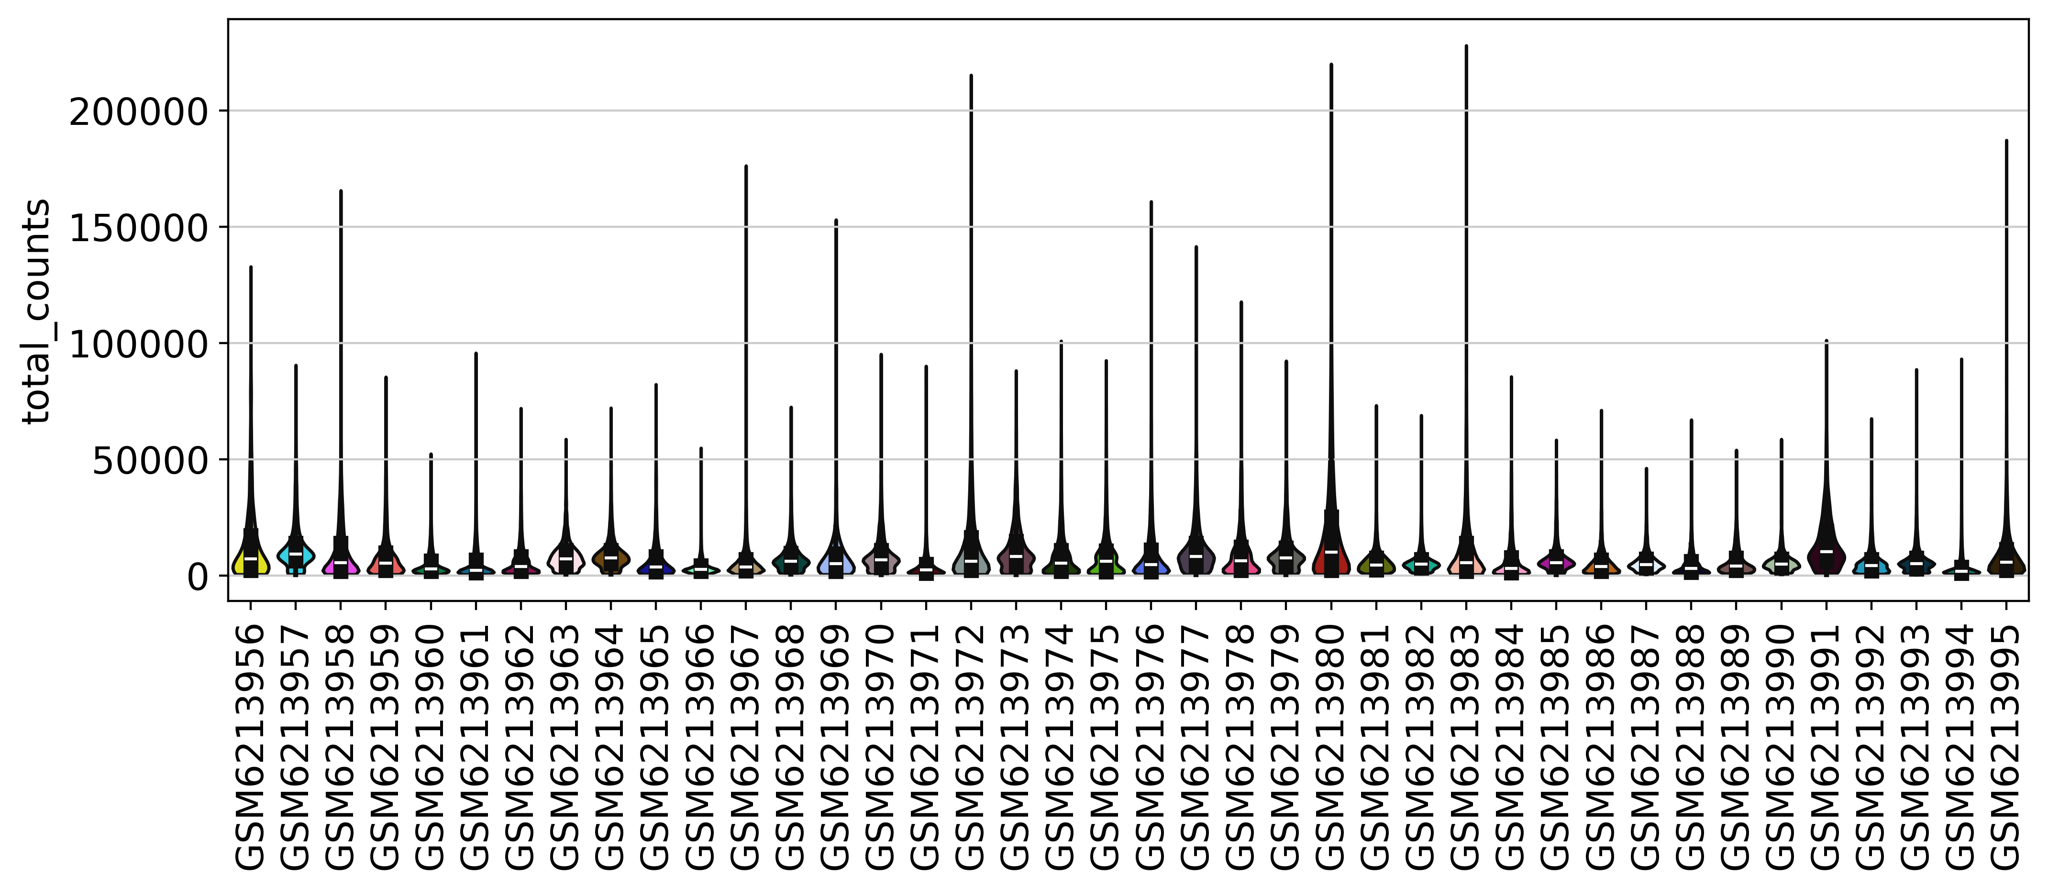

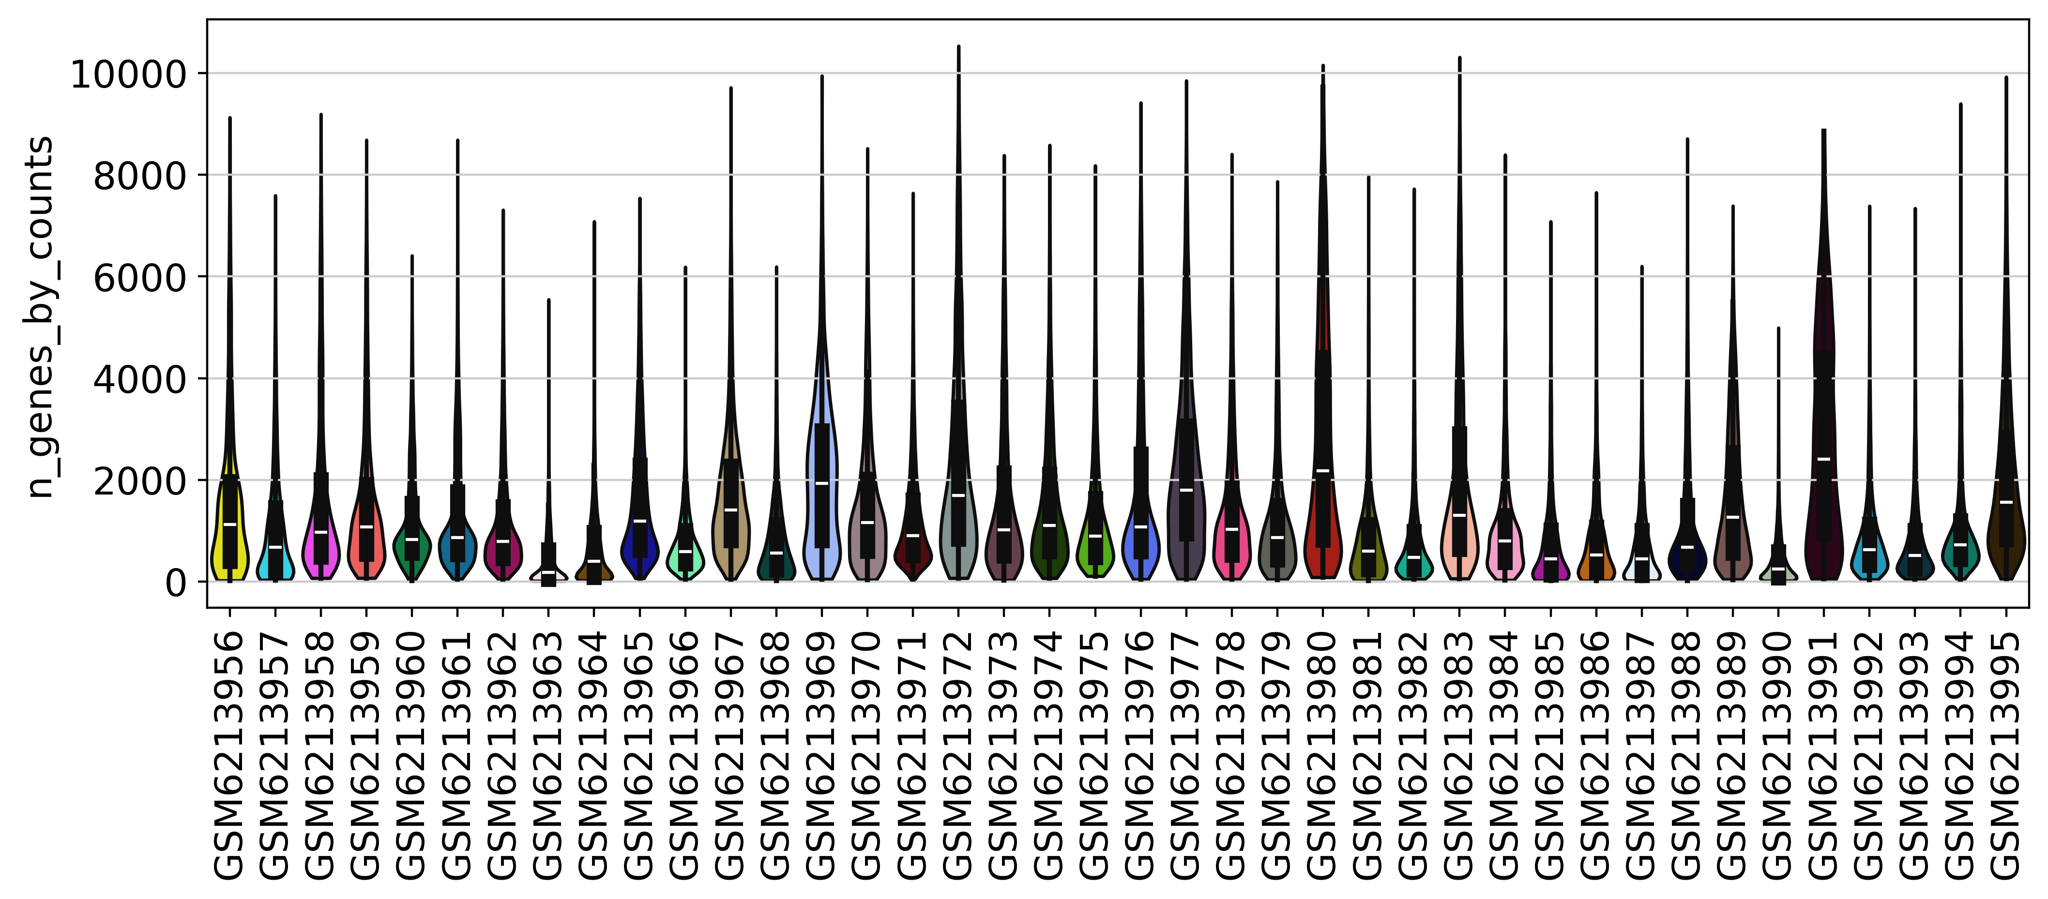

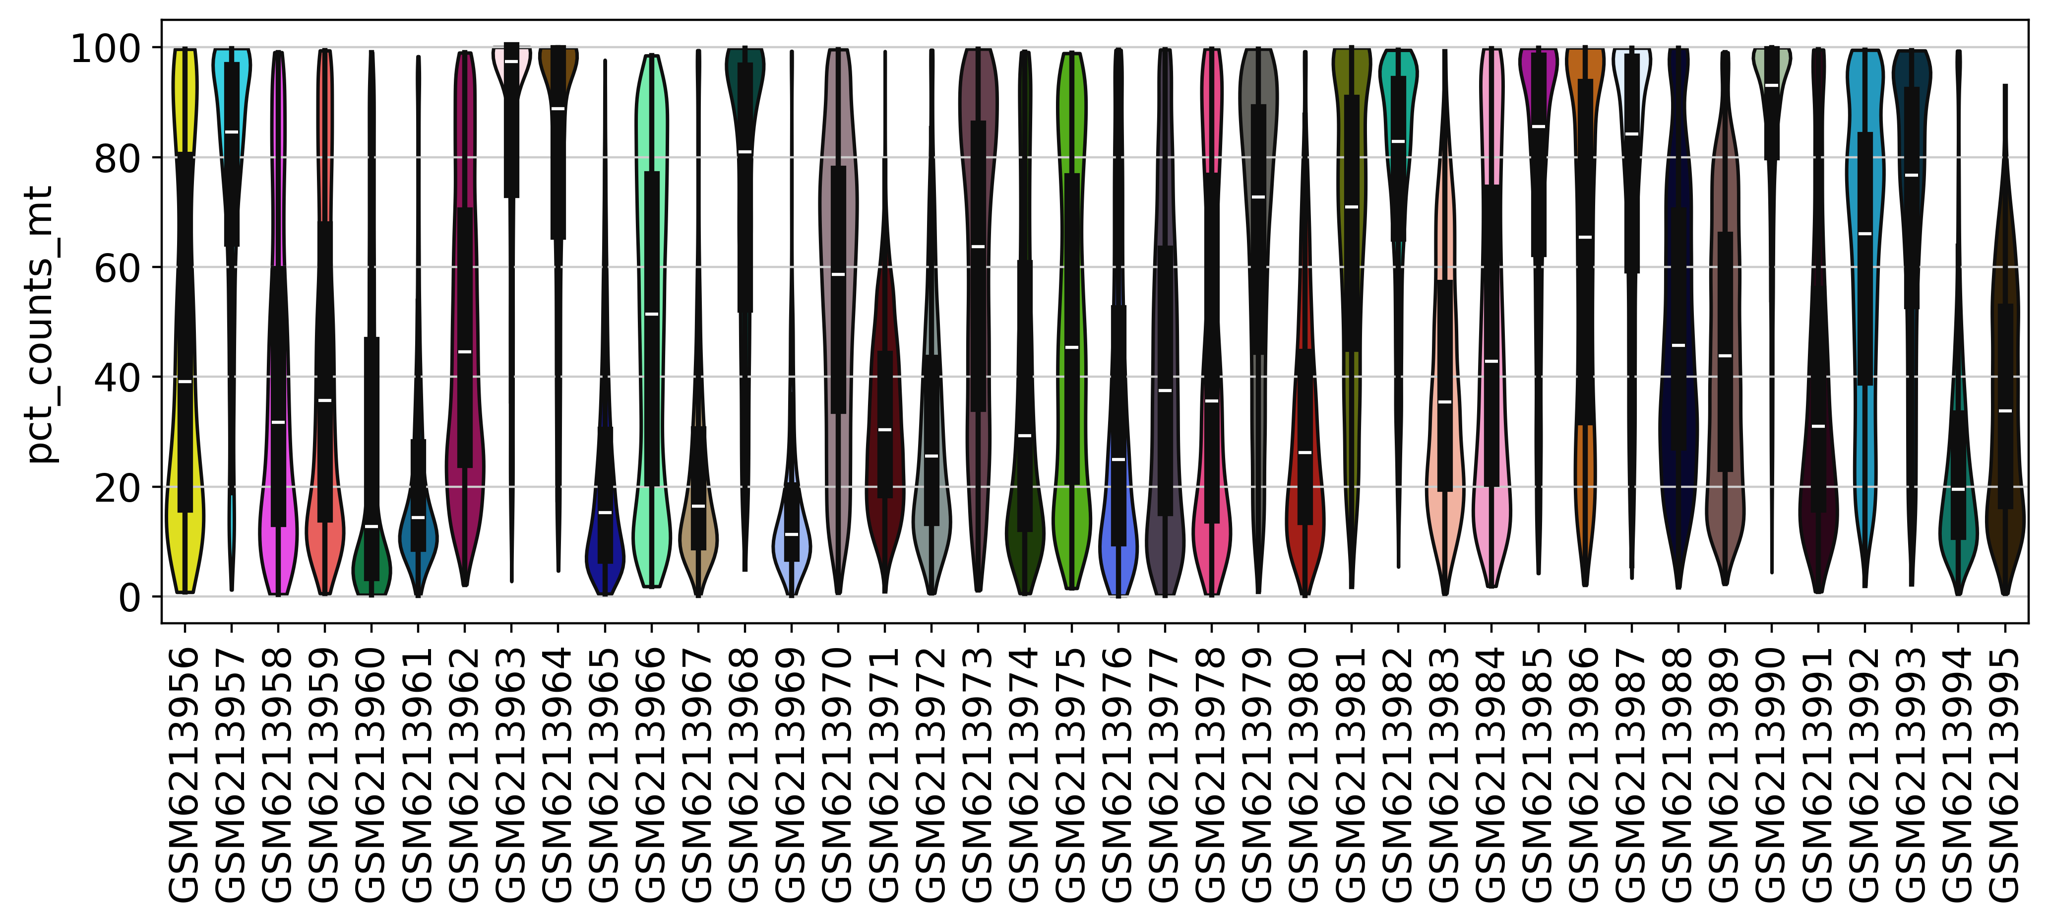

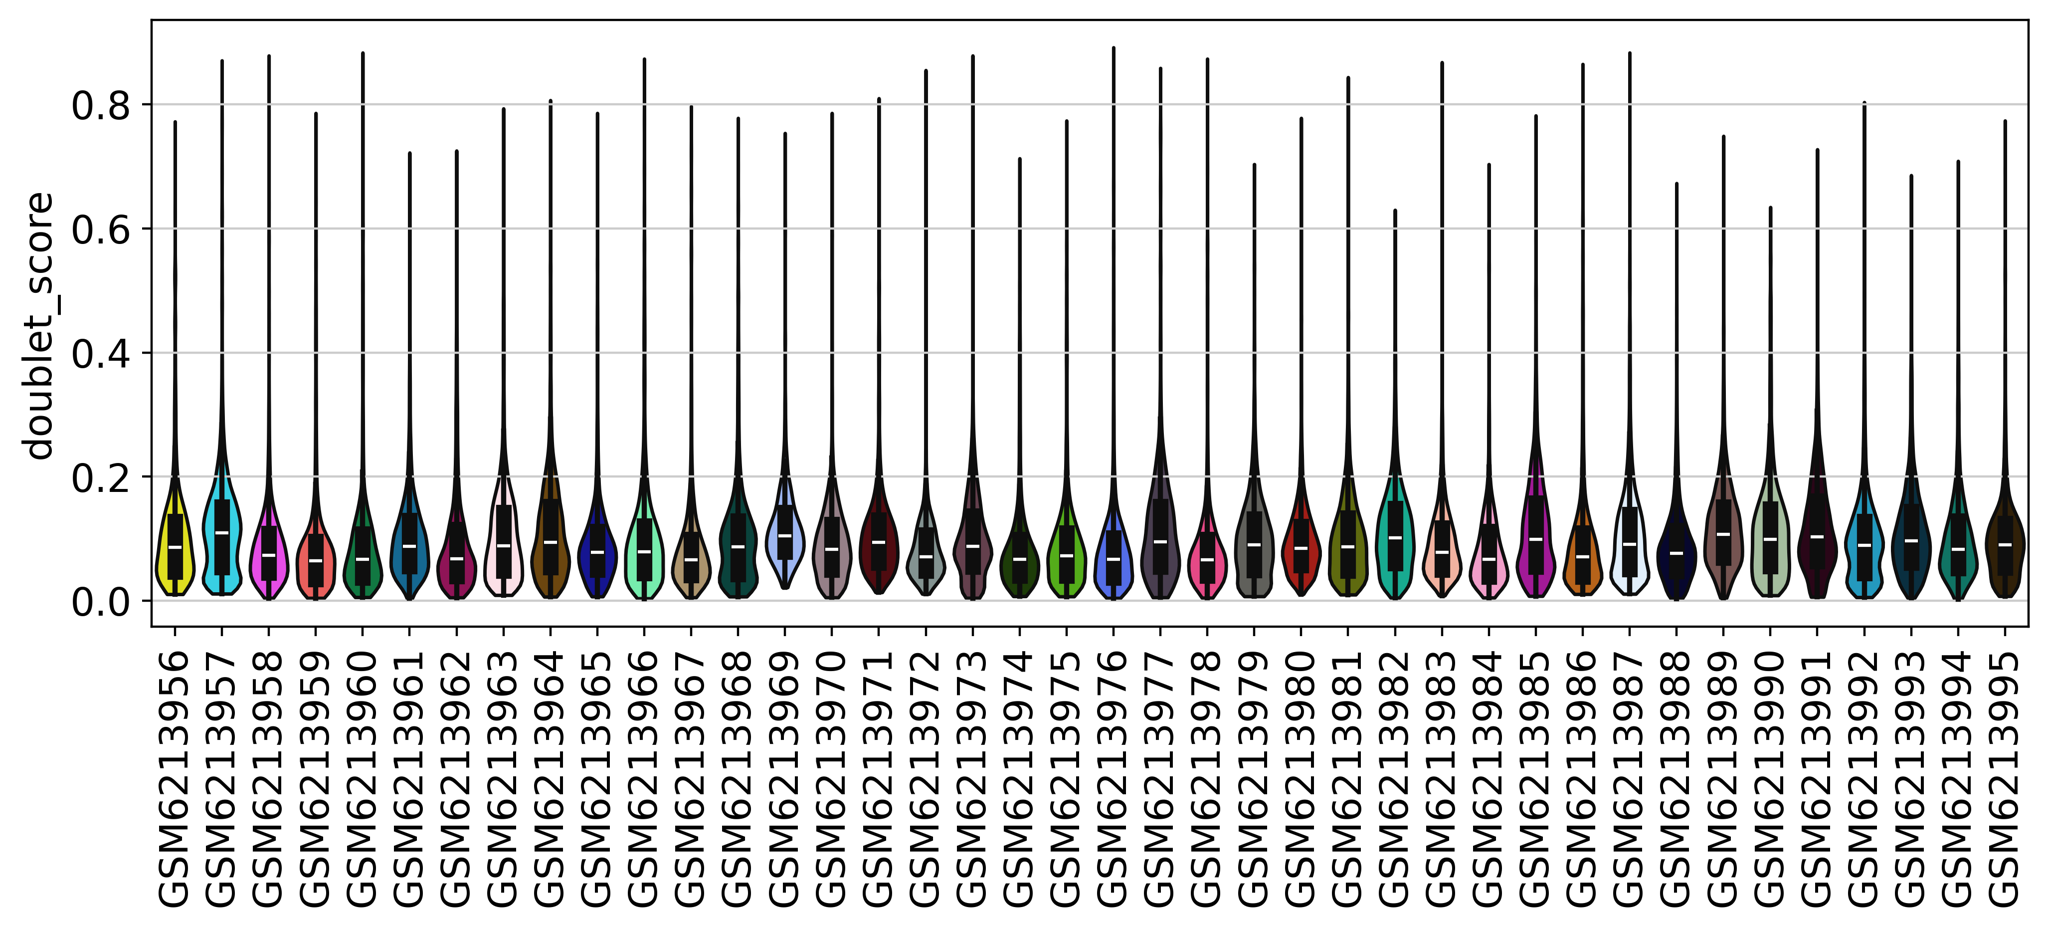

In [54]:
sc.settings.set_figure_params(dpi=200, dpi_save=400, figsize=(10,4), facecolor='white')
sc.pl.violin(adata,[ 'total_counts'], inner='box', size=0,  groupby='Sample', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='Sample', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'pct_counts_mt'], inner='box', size=0,  groupby='Sample', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'doublet_score'], inner='box', size=0,  groupby='Sample', multi_panel=False, rotation=90)

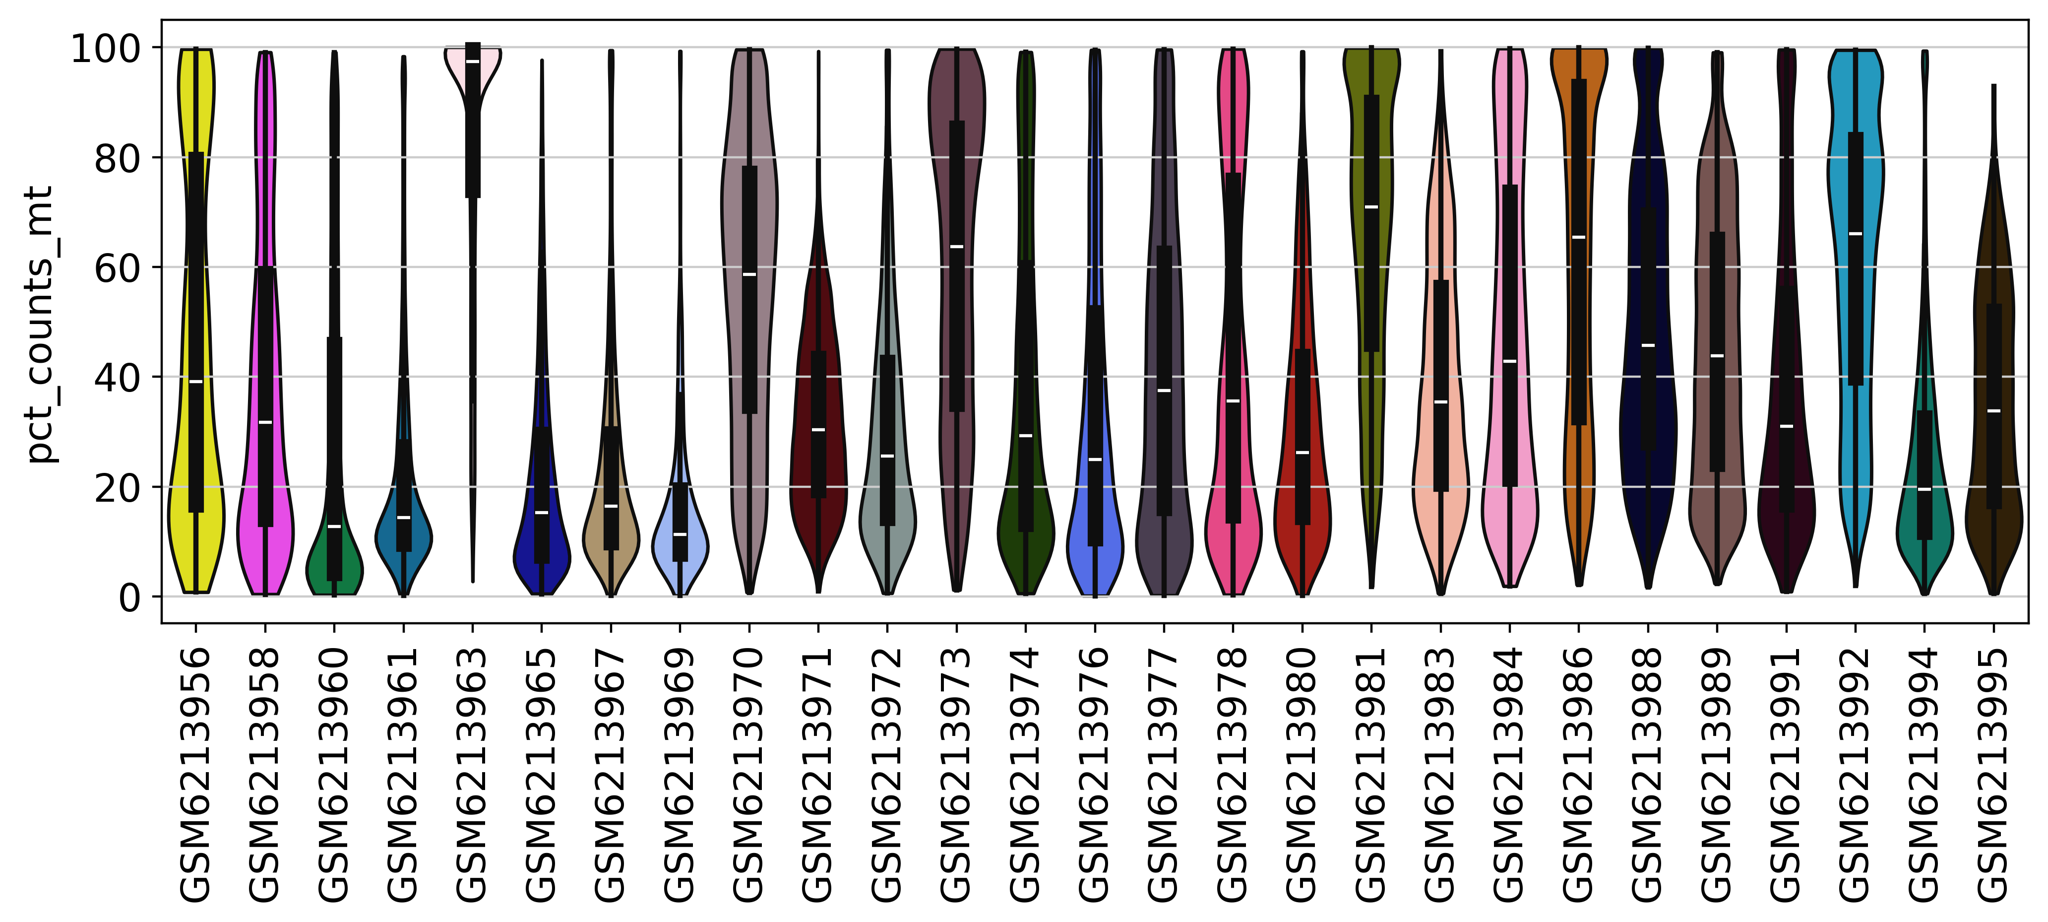

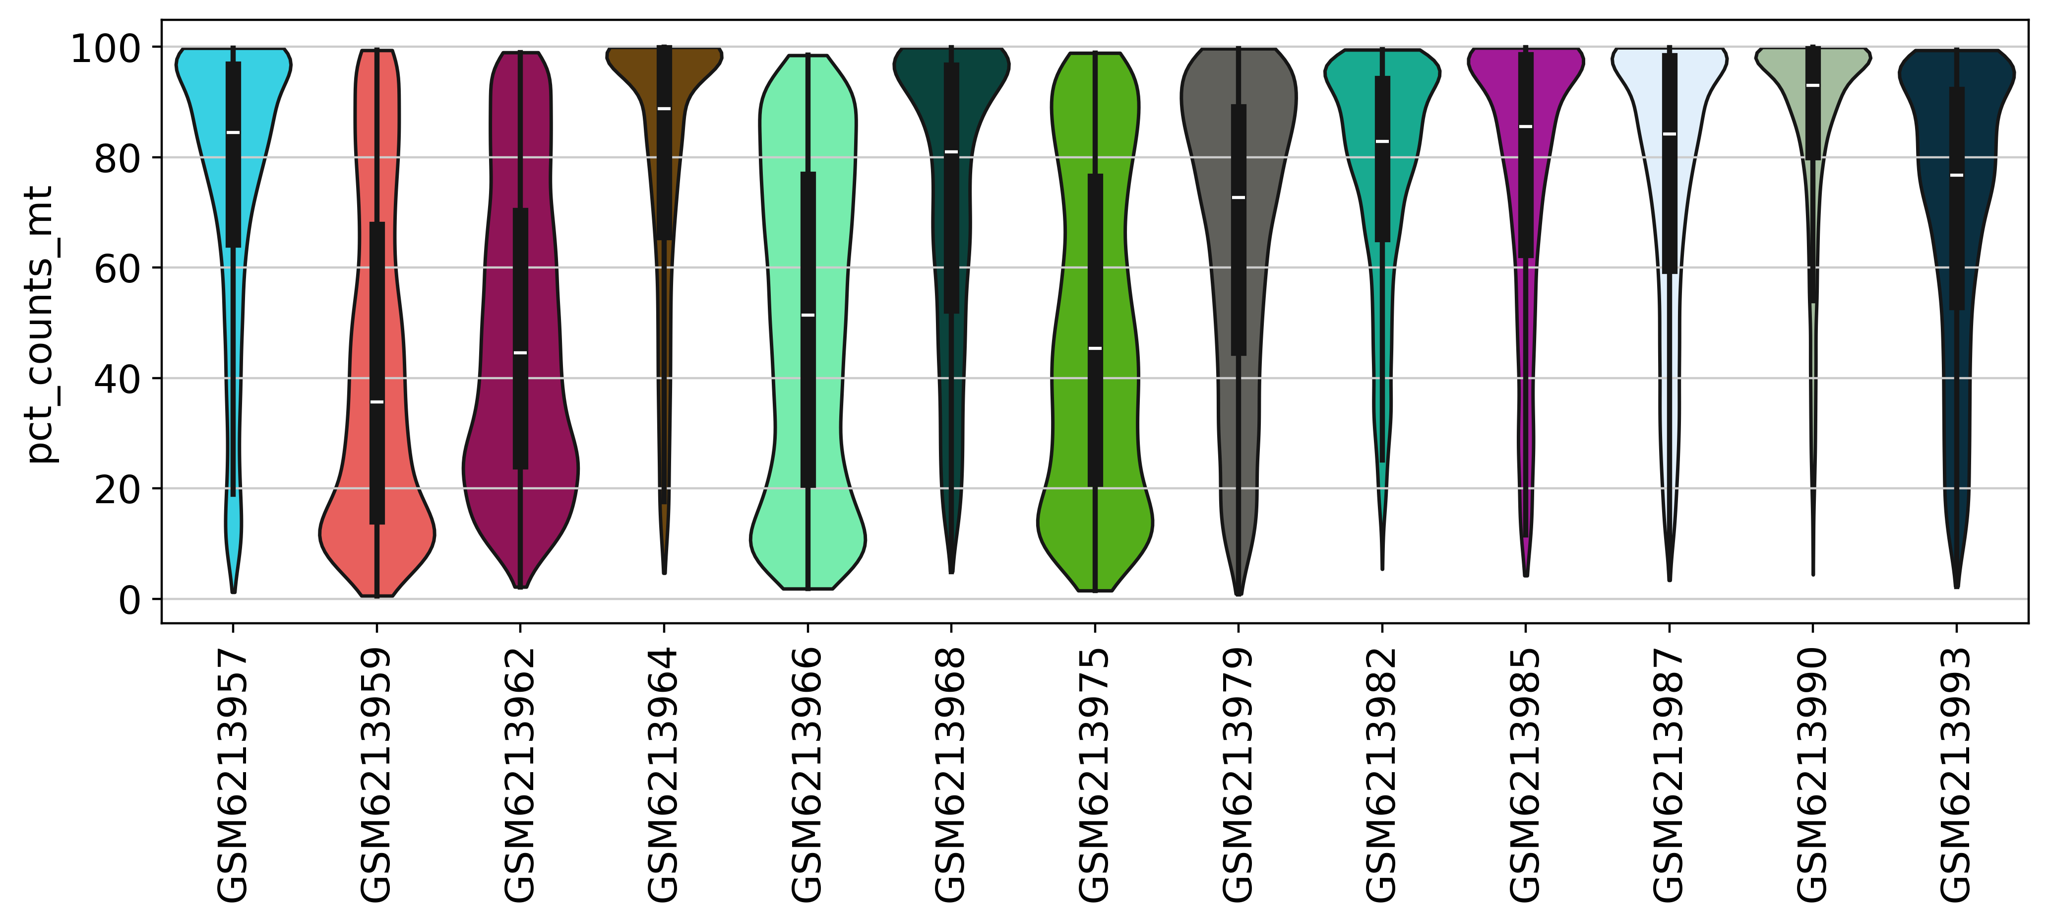

In [60]:
sc.pl.violin(adata[adata.obs.Condition == 'tumor'],[ 'pct_counts_mt'], inner='box', size=0,  groupby='Sample', multi_panel=False, rotation=90)
sc.pl.violin(adata[adata.obs.Condition != 'tumor'],[ 'pct_counts_mt'], inner='box', size=0,  groupby='Sample', multi_panel=False, rotation=90)

## Save the unprocessed anndata object

In [55]:
adata.write('{}Li_2023_unprocessed_05-06-2024.h5ad'.format(data_dir))

## Clustering analysis with minimal QC

In their paper, they got ~150k cells with some very shady QC. They are keeping some cells that have over 50% mitochondrial reads, and most of their cells are epithelial which we don't really care about anyways. Here we filter out cells with greater than 10% mitochondrial reads.


In [16]:
adata = sc.read_h5ad('{}Li_2023_unprocessed_05-06-2024.h5ad'.format(data_dir))

In [17]:
# just remove doublets for now 
adata = adata[adata.obs.predicted_doublet == False].copy()

In [18]:
# remove barcodes with too few or too many genes
adata = adata[adata.obs.n_genes_by_counts >= 500].copy()
adata = adata[adata.obs.n_genes_by_counts <= 5000].copy()

In [19]:
# remove cells with greater than 25,000 UMI
adata = adata[adata.obs.total_counts < 25000].copy()

In [20]:
# remove cells with greater than 10% mitochondrial reads:
adata = adata[adata.obs.pct_counts_mt < 10].copy()

In [34]:
adata.shape

(25787, 33538)

In [53]:
adata.obs.Condition.value_counts()

Condition
tumor     22674
normal     3113
Name: count, dtype: int64

In [21]:
adata.obs.Sample.value_counts()

Sample
GSM6213961    3627
GSM6213960    3144
GSM6213994    2265
GSM6213967    1974
GSM6213965    1906
GSM6213976    1742
GSM6213974    1114
GSM6213958     880
GSM6213959     874
GSM6213978     816
GSM6213966     702
GSM6213980     682
GSM6213977     620
GSM6213962     511
GSM6213995     486
GSM6213975     459
GSM6213972     450
GSM6213969     446
GSM6213971     423
GSM6213984     377
GSM6213989     301
GSM6213983     288
GSM6213988     212
GSM6213970     203
GSM6213973     162
GSM6213991     145
GSM6213979     142
GSM6213986     140
GSM6213956     134
GSM6213993     127
GSM6213957     121
GSM6213992      86
GSM6213985      57
GSM6213964      49
GSM6213981      31
GSM6213987      30
GSM6213963      20
GSM6213968      19
GSM6213990      15
GSM6213982       7
Name: count, dtype: int64

In [22]:
adata.obs.Patient.value_counts()

Patient
P15    4138
P25    3315
P14    3144
P18    2608
P32    2478
P19    1993
P12    1754
P27    1640
P21     649
P26     620
P24     612
P33     486
P31     461
P29     434
P23     423
P30     382
P28     326
P11     255
P17      69
Name: count, dtype: int64

## Initial clustering

In [23]:
# normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# retain the "Raw" adata object for later
adata.raw = adata

In [24]:
# identify HVGs
sc.pp.highly_variable_genes(
    adata
)

In [25]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [104]:
#sc.external.pp.harmony_integrate(adata, key = 'Patient')

2024-06-05 16:30:36,271 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-05 16:30:58,577 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-05 16:31:00,816 - harmonypy - INFO - Iteration 1 of 10
2024-06-05 16:32:40,627 - harmonypy - INFO - Iteration 2 of 10
2024-06-05 16:34:25,263 - harmonypy - INFO - Iteration 3 of 10
2024-06-05 16:36:11,523 - harmonypy - INFO - Iteration 4 of 10
2024-06-05 16:37:50,166 - harmonypy - INFO - Iteration 5 of 10
2024-06-05 16:39:29,373 - harmonypy - INFO - Iteration 6 of 10
2024-06-05 16:41:07,372 - harmonypy - INFO - Iteration 7 of 10
2024-06-05 16:41:58,340 - harmonypy - INFO - Converged after 7 iterations


In [26]:
sc.pp.neighbors(adata, use_rep = 'X_pca', n_neighbors=20, n_pcs=30, metric='cosine')


/home/groups/singlecell/smorabito/.conda/envs/serp-scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
sc.tl.umap(adata, min_dist=0.35, method='umap')

In [28]:
# clustering 
for res in [0.5]:
    print(res)
    x = 'leiden_' + str(res)
    sc.tl.leiden(adata, resolution=res)
    adata.obs[x] = adata.obs.leiden
    


# sc.tl.leiden(adata, resolution=1)
# adata.obs['leiden_1.0'] = adata.obs.leiden
# sc.tl.leiden(adata, resolution=2)
# adata.obs['leiden_2.0']


0.5


/scratch_tmp/24197881/ipykernel_204395/2525281208.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res)


In [43]:
sc.tl.dendrogram(adata, groupby='leiden_0.5')

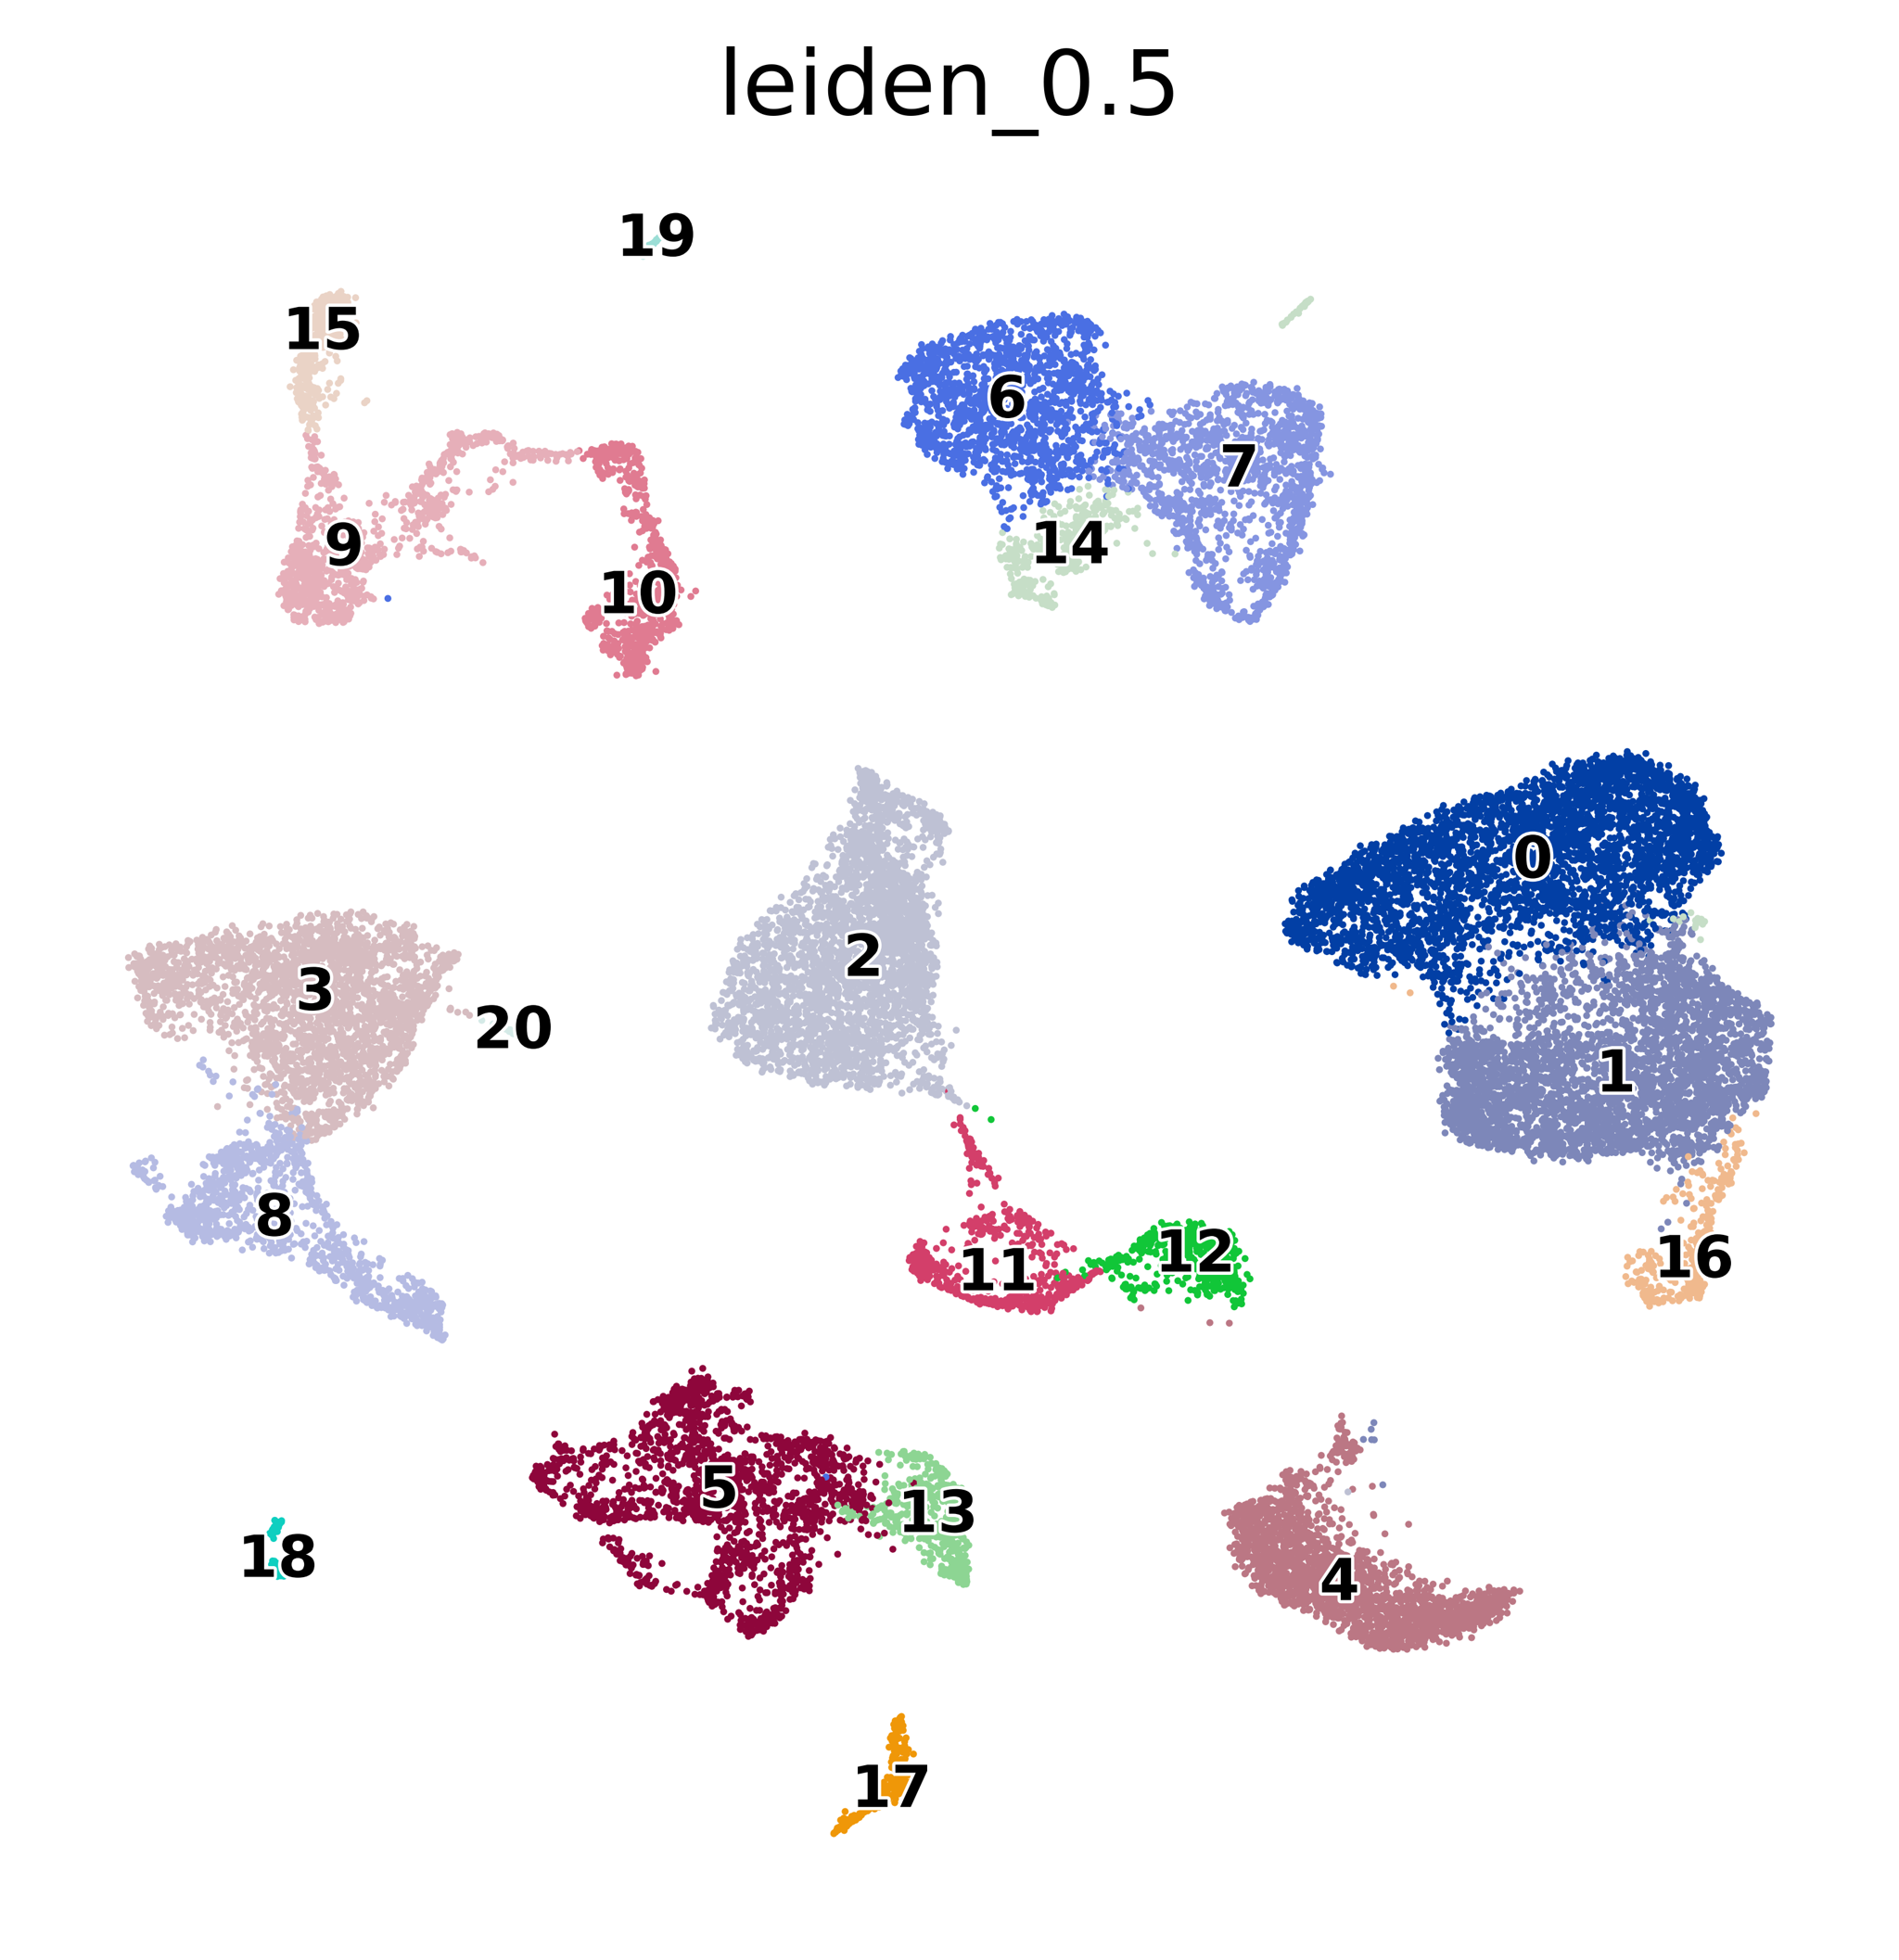

In [29]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color=['leiden_0.5'],
    frameon=False, 
    legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    ncols=1,
    save='_leiden.pdf'
)

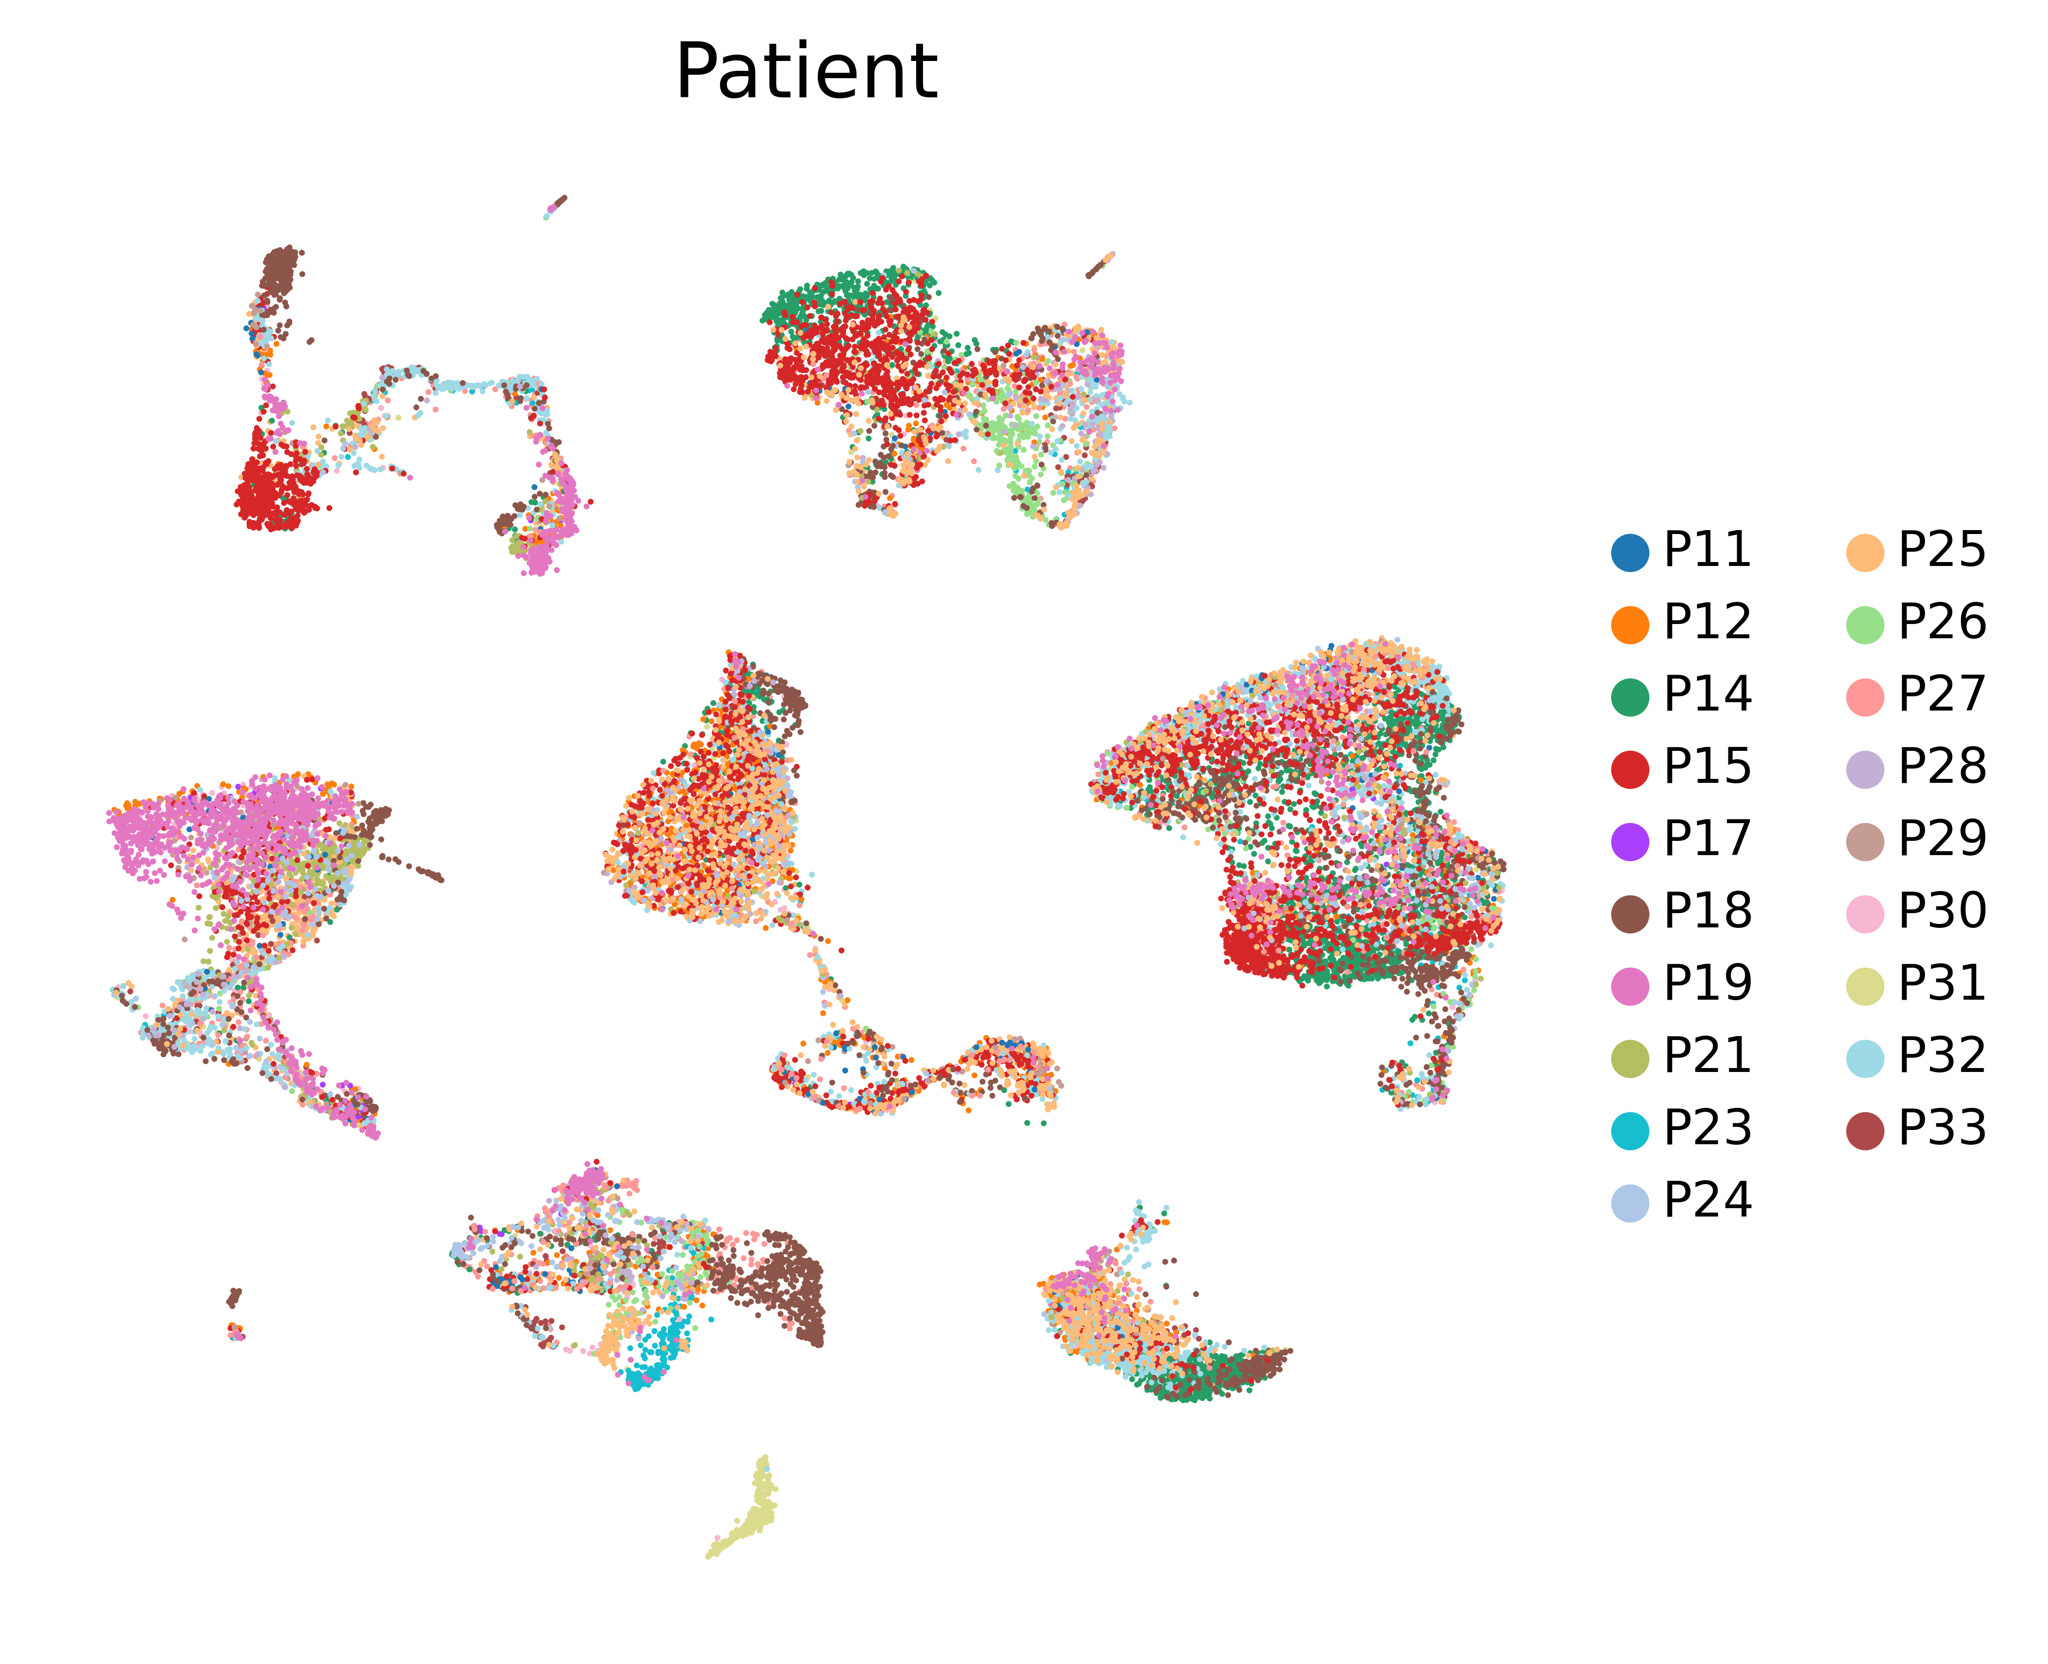

In [30]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color=['Patient'],
    frameon=False, 
    #legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    ncols=2,
    #title='',
    save='_patients.pdf'
)

categories: 0, 1, 2, etc.
var_group_labels: Immune, CD4 + T, CD8+ T, etc.


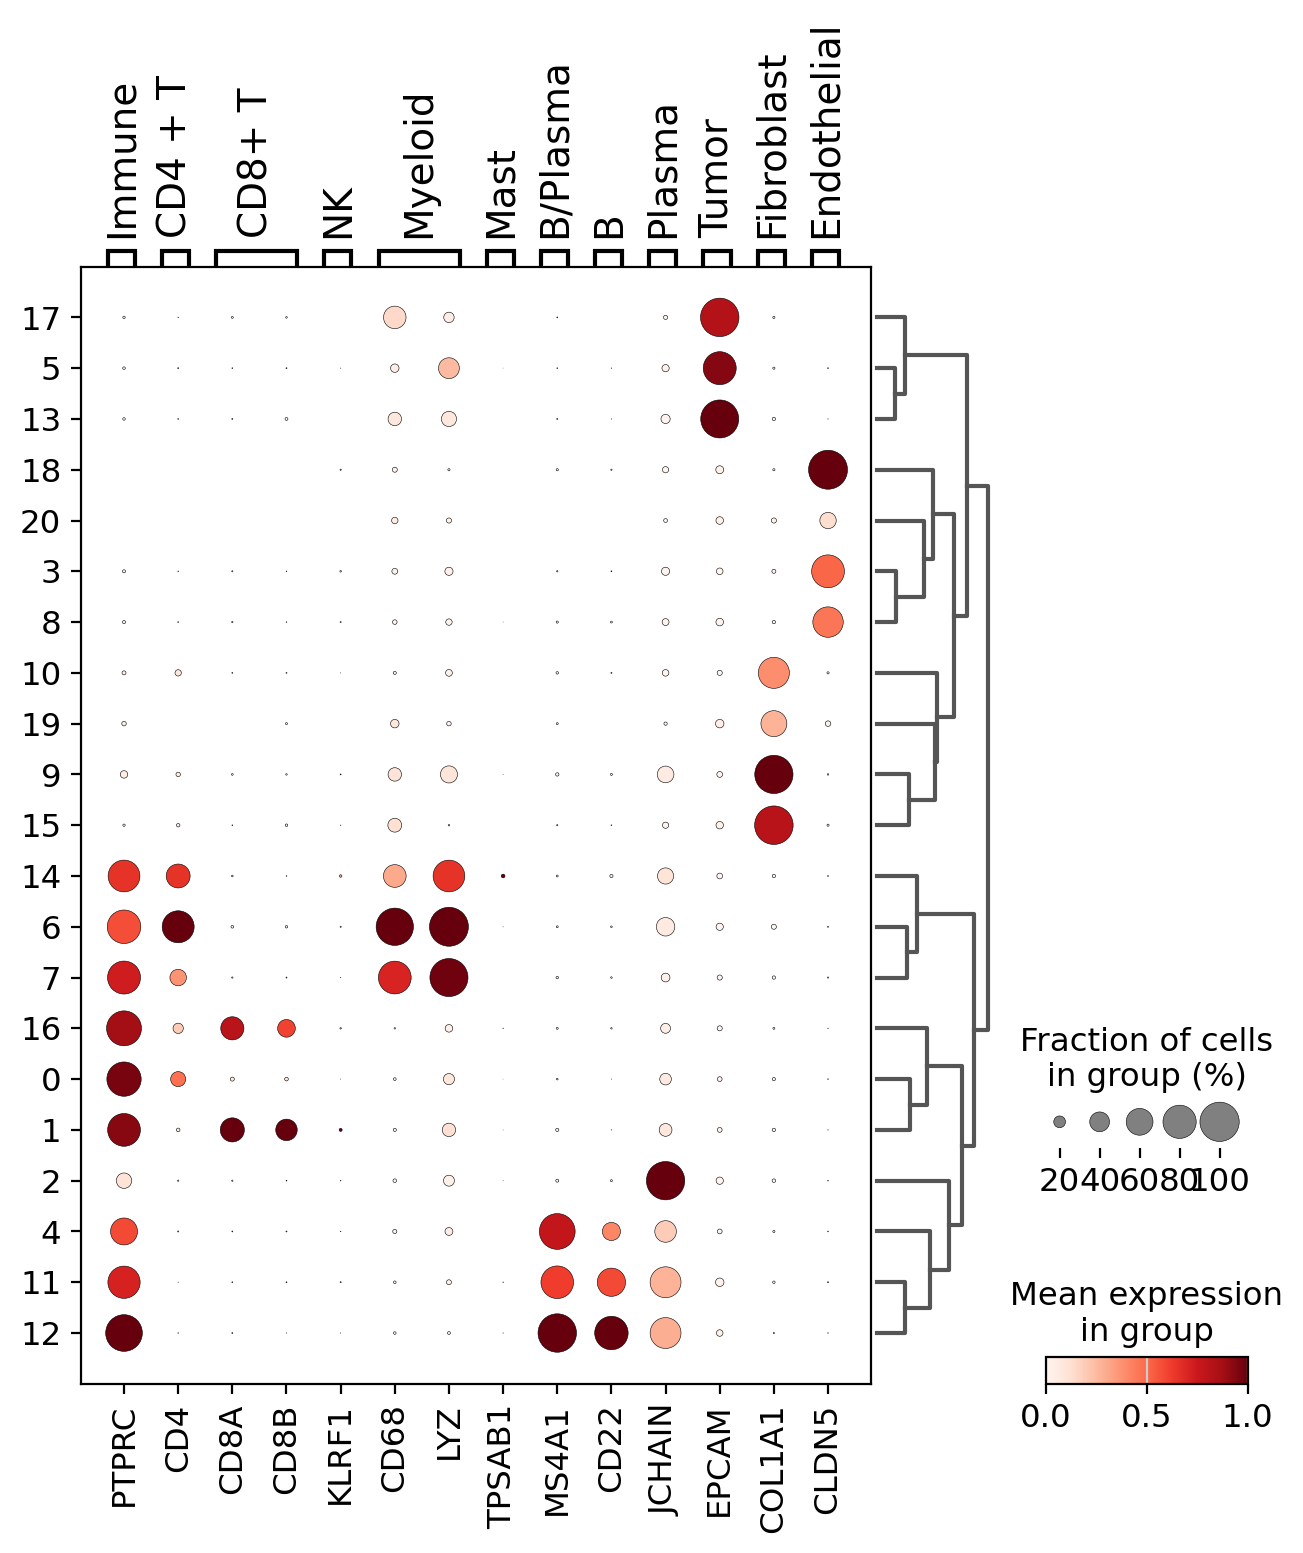

In [44]:

sc.settings.set_figure_params(dpi=100, dpi_save=300, figsize=(15,5), facecolor='white')

marker_dict = {
    'Immune': ['PTPRC'],
    'CD4 + T': ['CD4'],
    'CD8+ T': ['CD8A', 'CD8B'],
    'NK': ['KLRF1'],
    'Myeloid': ['CD68', 'LYZ'],
    'Mast': ['TPSAB1'],
    'B/Plasma': ['MS4A1'],
    'B': ['CD22'],
    'Plasma': ['JCHAIN'],
    'Tumor': ['EPCAM'],
    'Fibroblast': ['COL1A1'],
    'Endothelial': ['CLDN5']
}


sc.pl.dotplot(
    adata, marker_dict, 'leiden_0.5',
    dendrogram=True,
    standard_scale='var', swap_axes=False,
    save = '_leiden_markers_primary.pdf'
)

#sc.pl.dotplot(adata, marker_dict, groupby='leiden', figsize=(12,6), standard_scale='var',  dendrogram=True, save='markers.pdf')

categories: 0, 1, 2, etc.
var_group_labels: T cell, Myeloid, Fibroblast, etc.


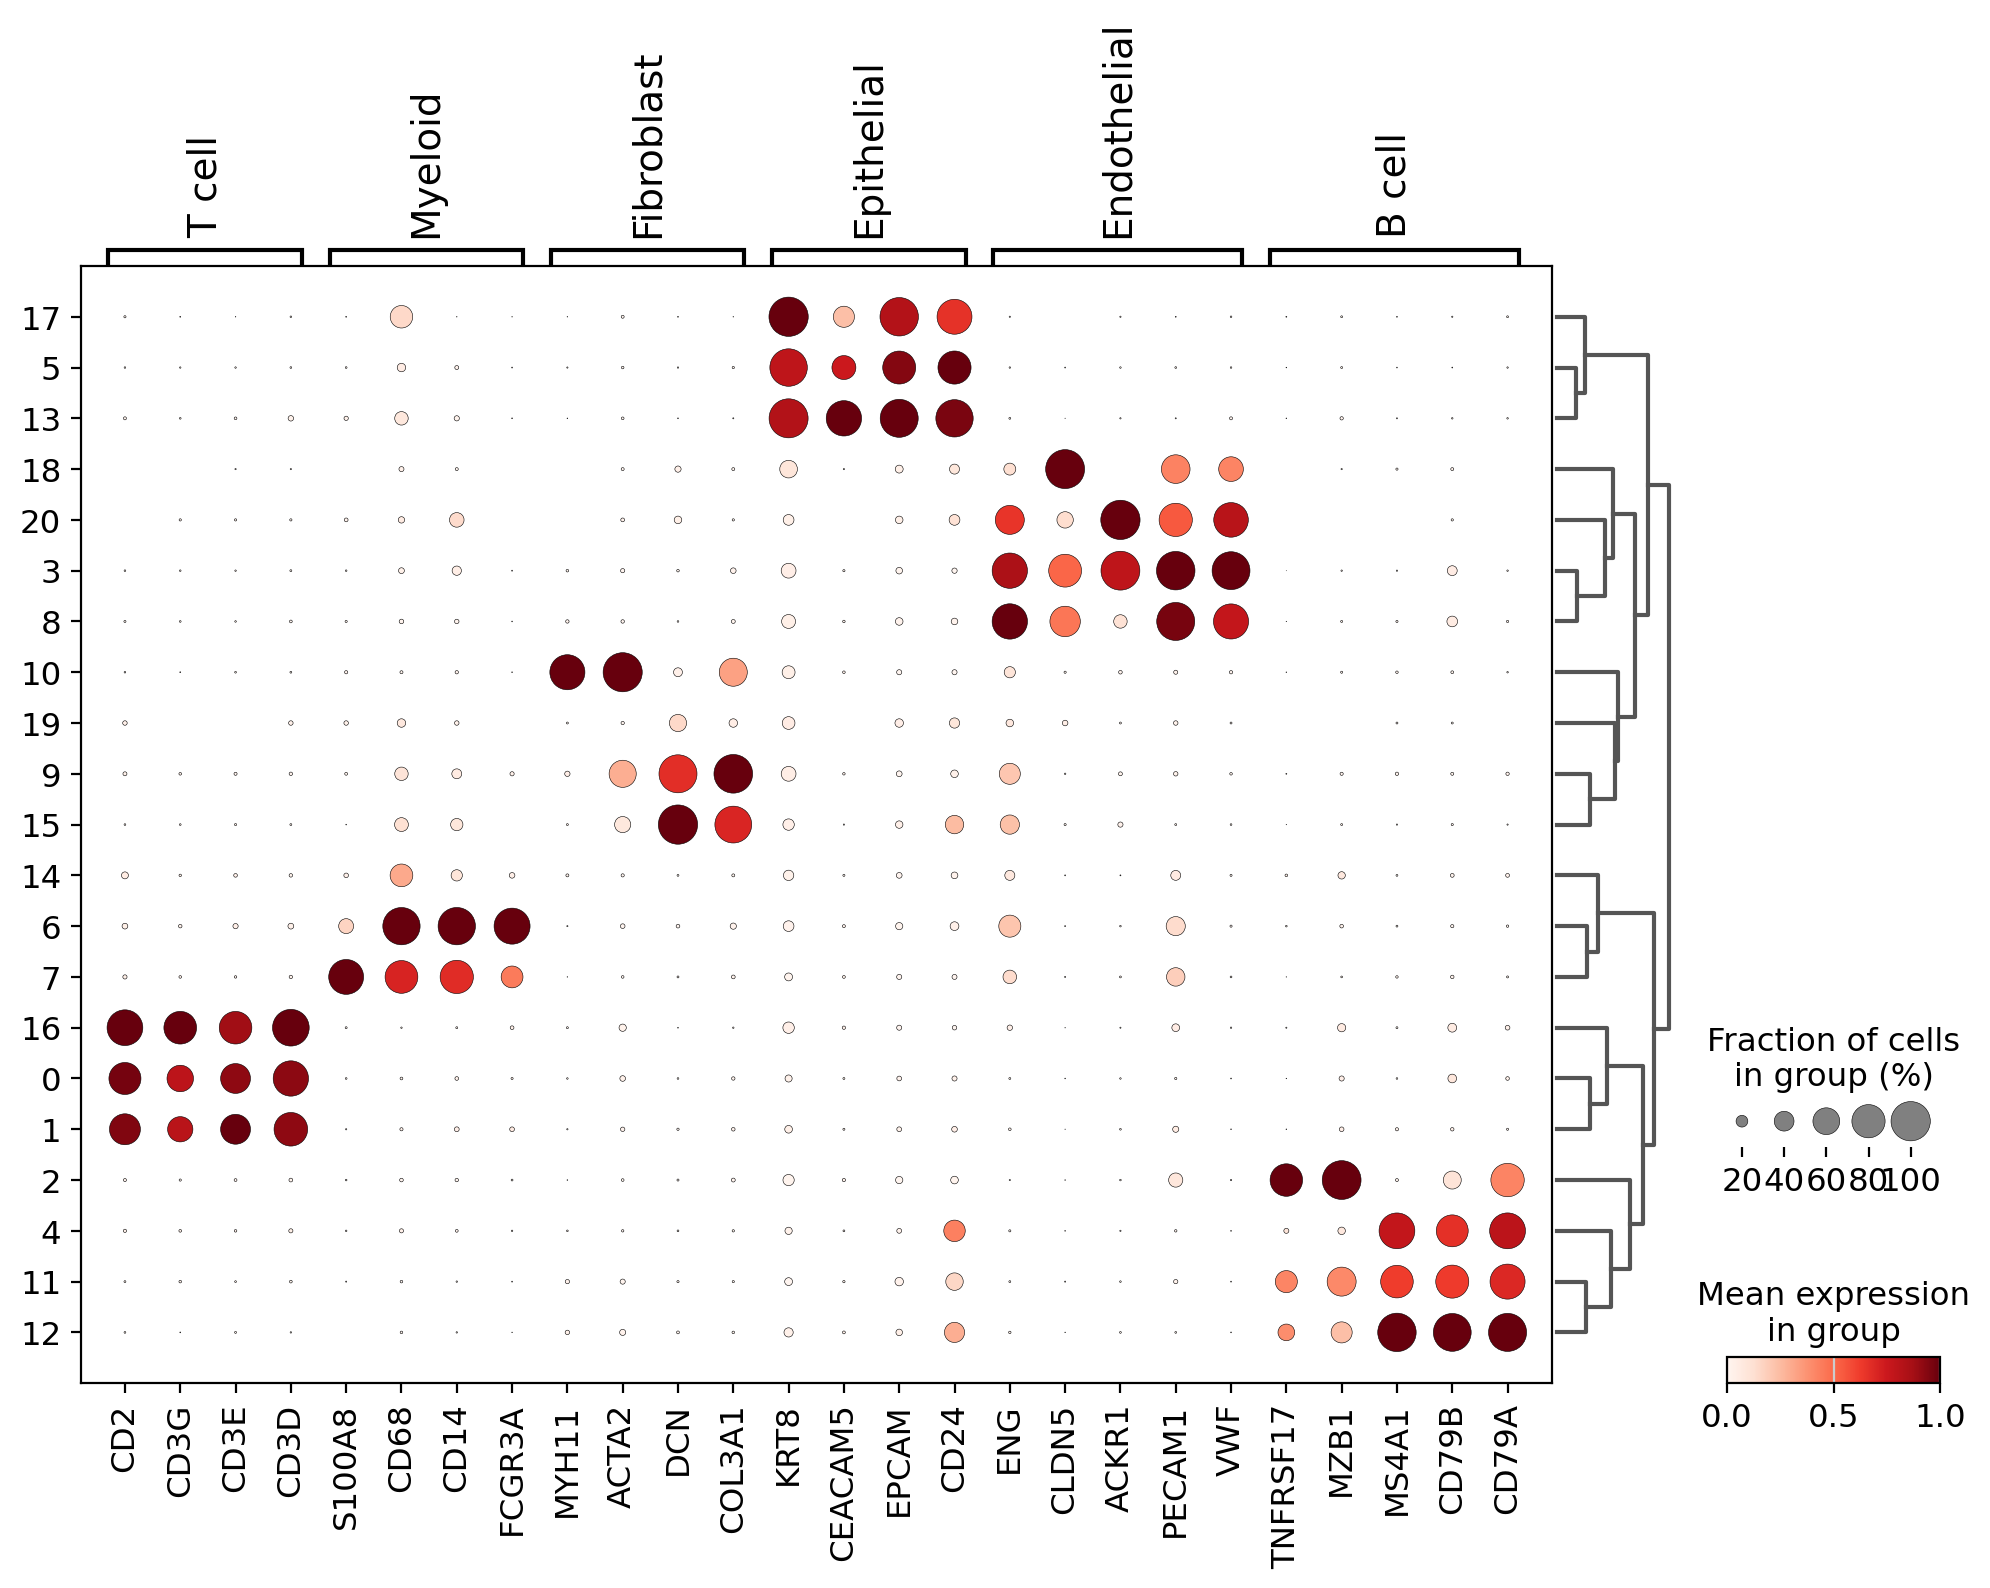

In [51]:

sc.settings.set_figure_params(dpi=100, dpi_save=300, figsize=(15,5), facecolor='white')

markers = {
    'T cell': ['CD2', 'CD3G', 'CD3E', 'CD3D'],
    'Myeloid': ['S100A8', 'CD68', 'CD14', 'FCGR3A'],
    'Fibroblast': ['MYH11', 'ACTA2', 'DCN', 'COL3A1'],
    'Epithelial' :['KRT8', 'CEACAM5', 'EPCAM', 'CD24'],
    'Endothelial': ['ENG', 'CLDN5', 'ACKR1', 'PECAM1', 'VWF'],
    'B cell': ['TNFRSF17', 'MZB1', 'MS4A1', 'CD79B', 'CD79A']
}


sc.pl.dotplot(
    adata, markers, 'leiden_0.5',
    dendrogram=True,
    standard_scale='var', swap_axes=False,
    save = '_leiden_markers_lietal.pdf'
)

#sc.pl.dotplot(adata, marker_dict, groupby='leiden', figsize=(12,6), standard_scale='var',  dendrogram=True, save='markers.pdf')

In [57]:
# immune cell or not 
immune_clusters = [0, 1, 16, 2, 4, 11, 12, 6, 7, 14]
adata.obs['immune'] = ['immune' if x in immune_clusters else 'other' for x in adata.obs['leiden_0.5'].astype(int).to_list()]


In [58]:
import seaborn as sns

In [36]:
adata.obs.columns

Index(['Sample', 'bc', 'batch', 'doublet_score', 'predicted_doublet', 'ID',
       'Sample_num', 'Patient', 'Tissue', 'Condition', 'Treatment',
       'Technology', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'leiden', 'leiden_0.5'],
      dtype='object')

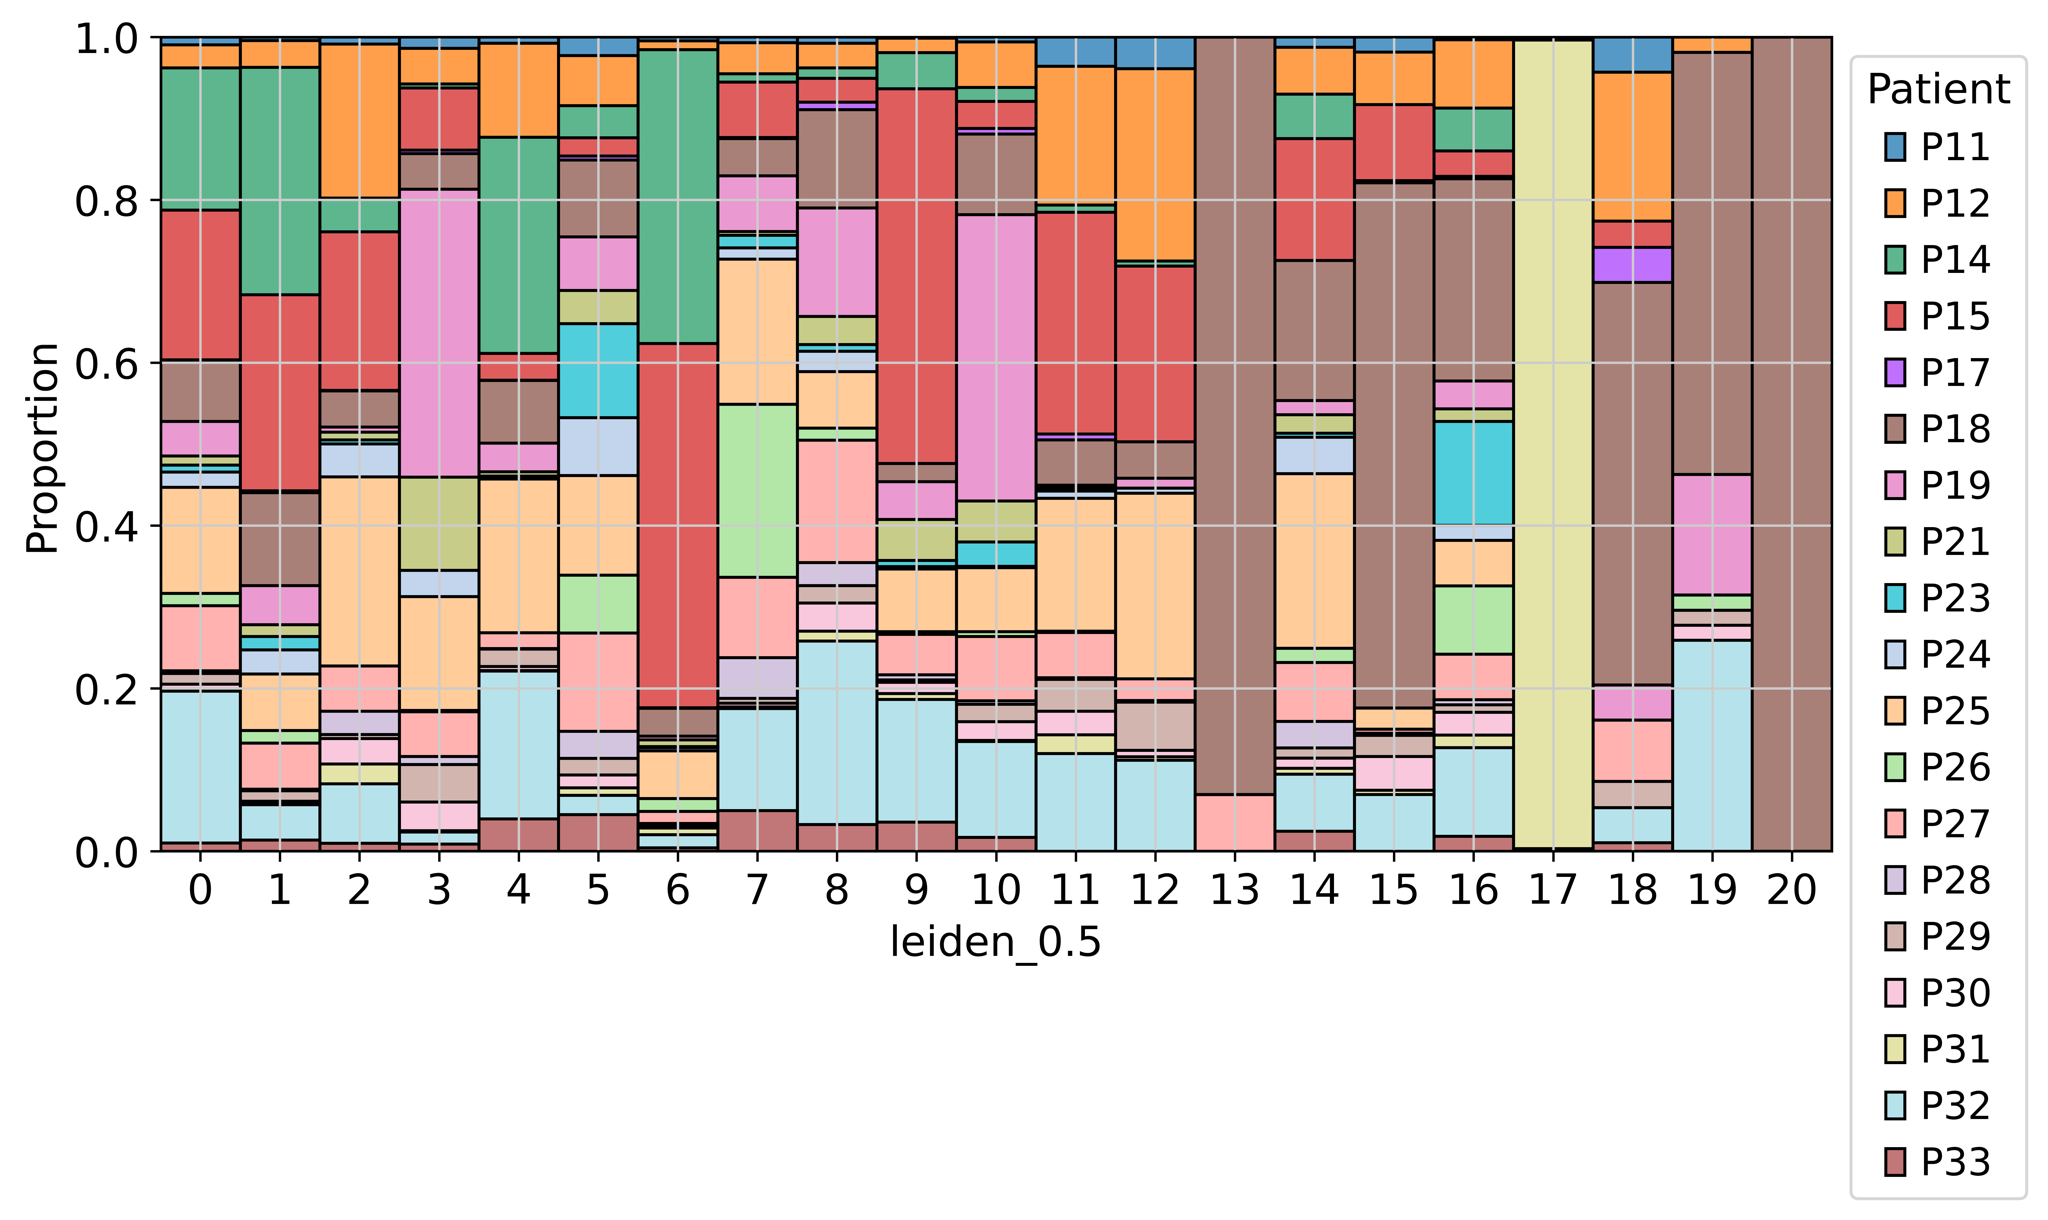

In [37]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(10,5), facecolor='white')
ax = sns.histplot(
    data = adata.obs,
    x = 'leiden_0.5',
    hue = 'Patient',
    multiple='fill', stat='proportion',
    discrete=True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

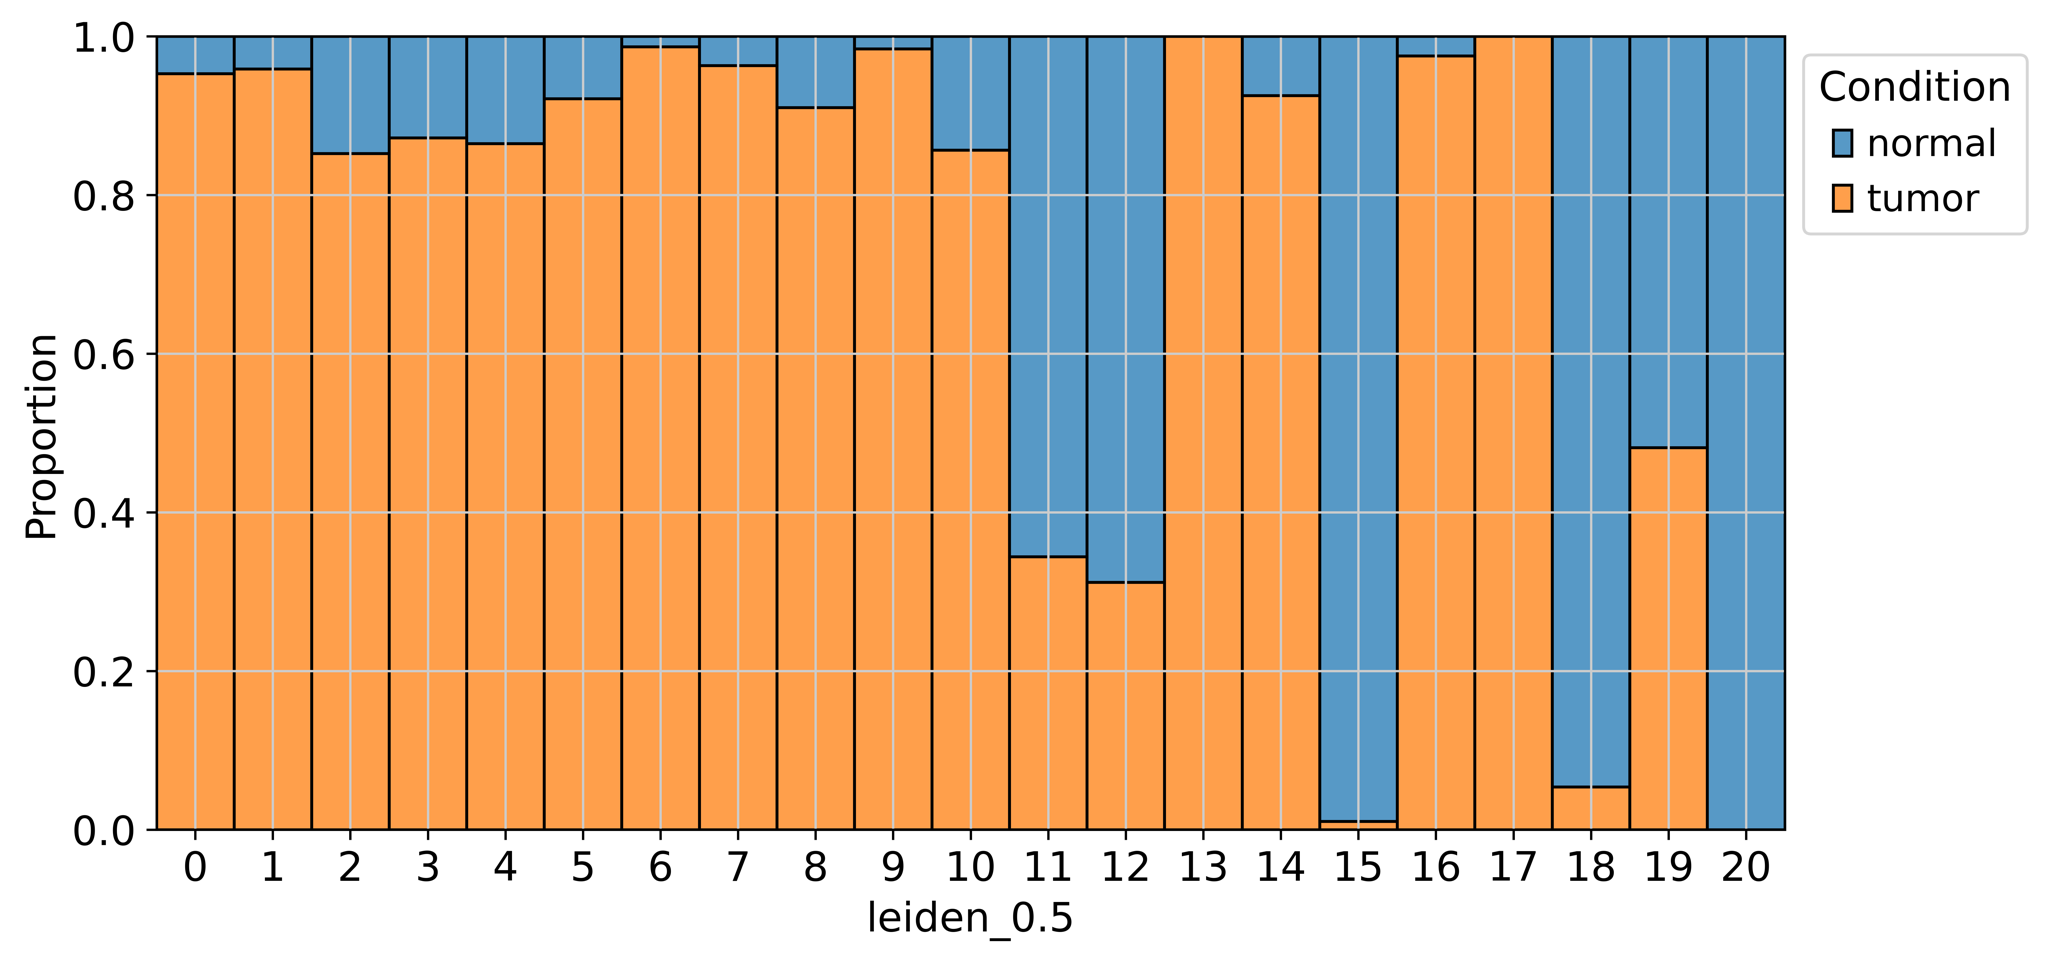

In [38]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(10,5), facecolor='white')
ax = sns.histplot(
    data = adata.obs,
    x = 'leiden_0.5',
    hue = 'Condition',
    multiple='fill', stat='proportion',
    discrete=True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

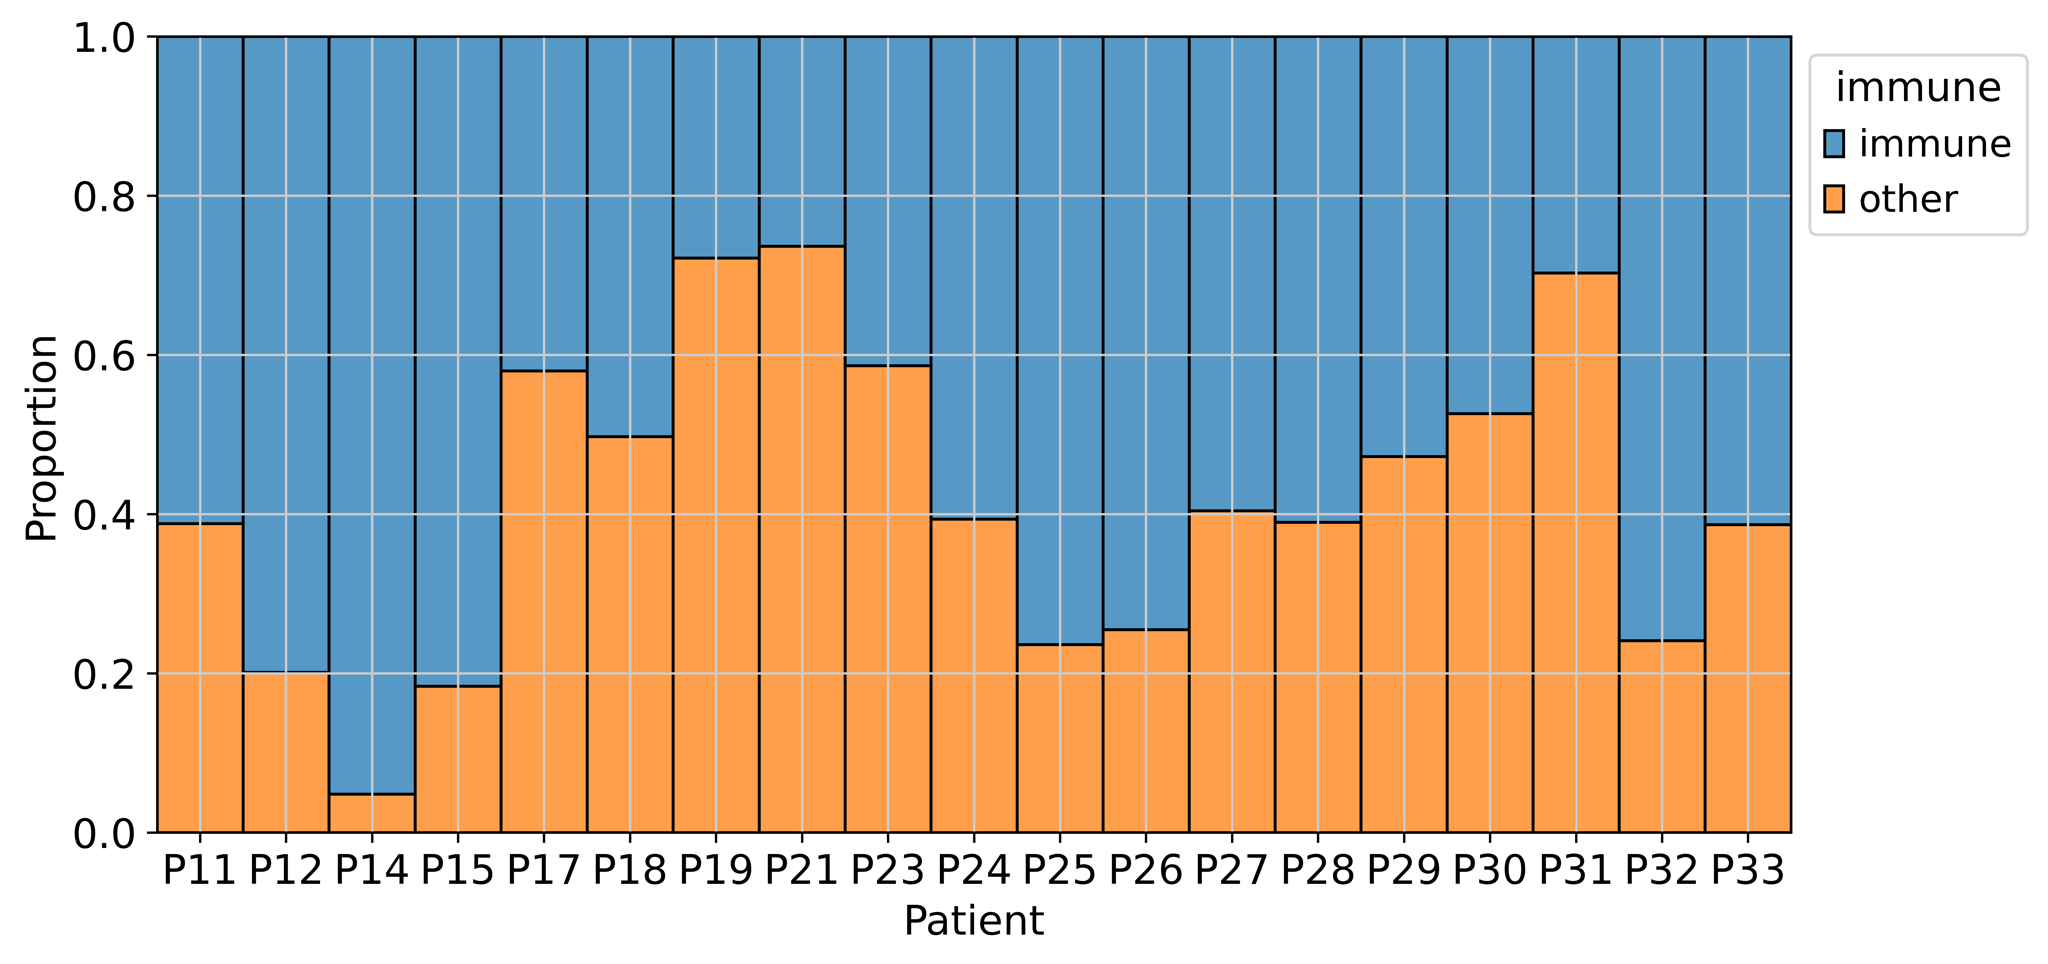

In [61]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(10,5), facecolor='white')
ax = sns.histplot(
    data = adata.obs,
    x = 'Patient',
    hue = 'immune',
    multiple='fill', stat='proportion',
    discrete=True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<Axes: xlabel='Patient'>

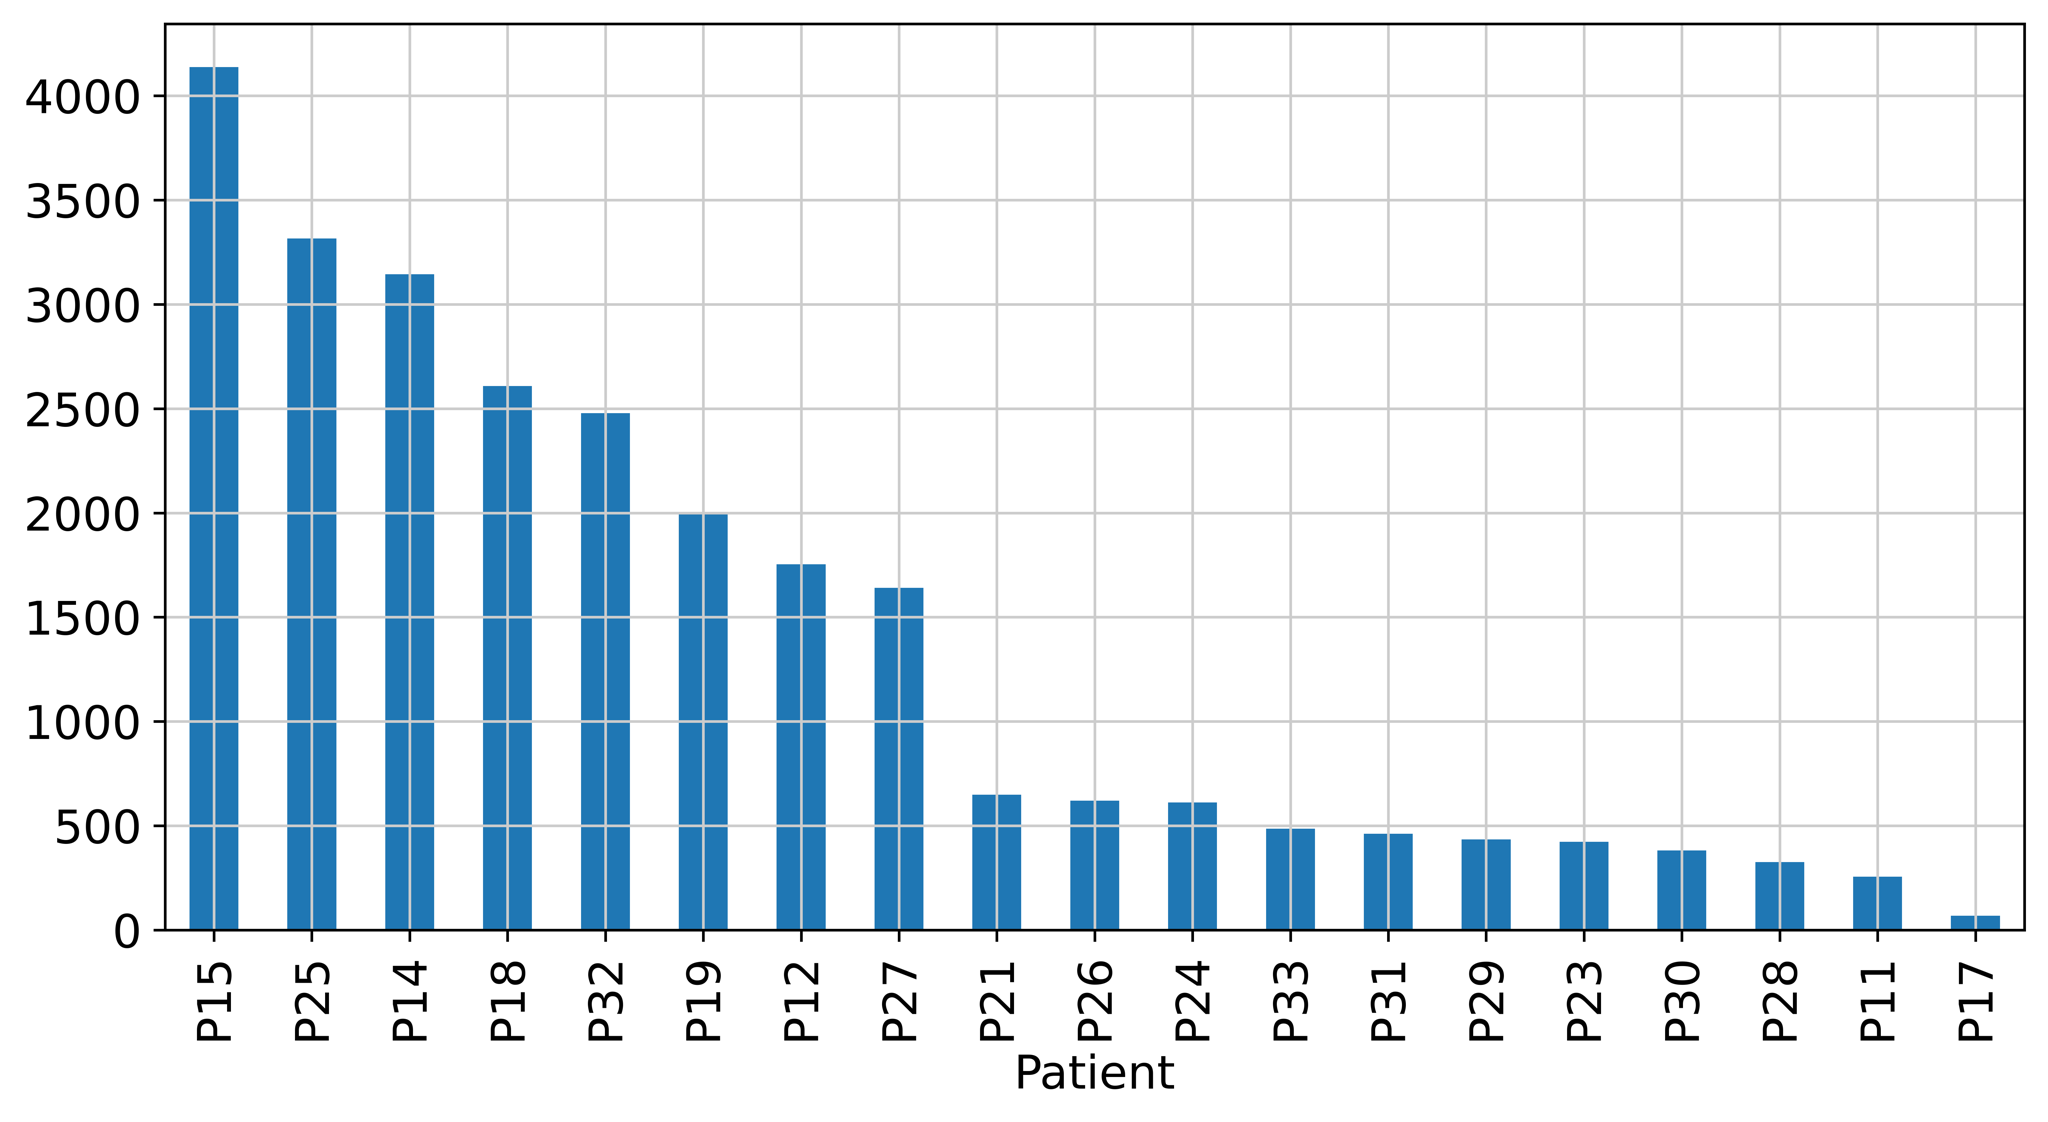

In [67]:
adata.obs.Patient.value_counts().plot.bar()

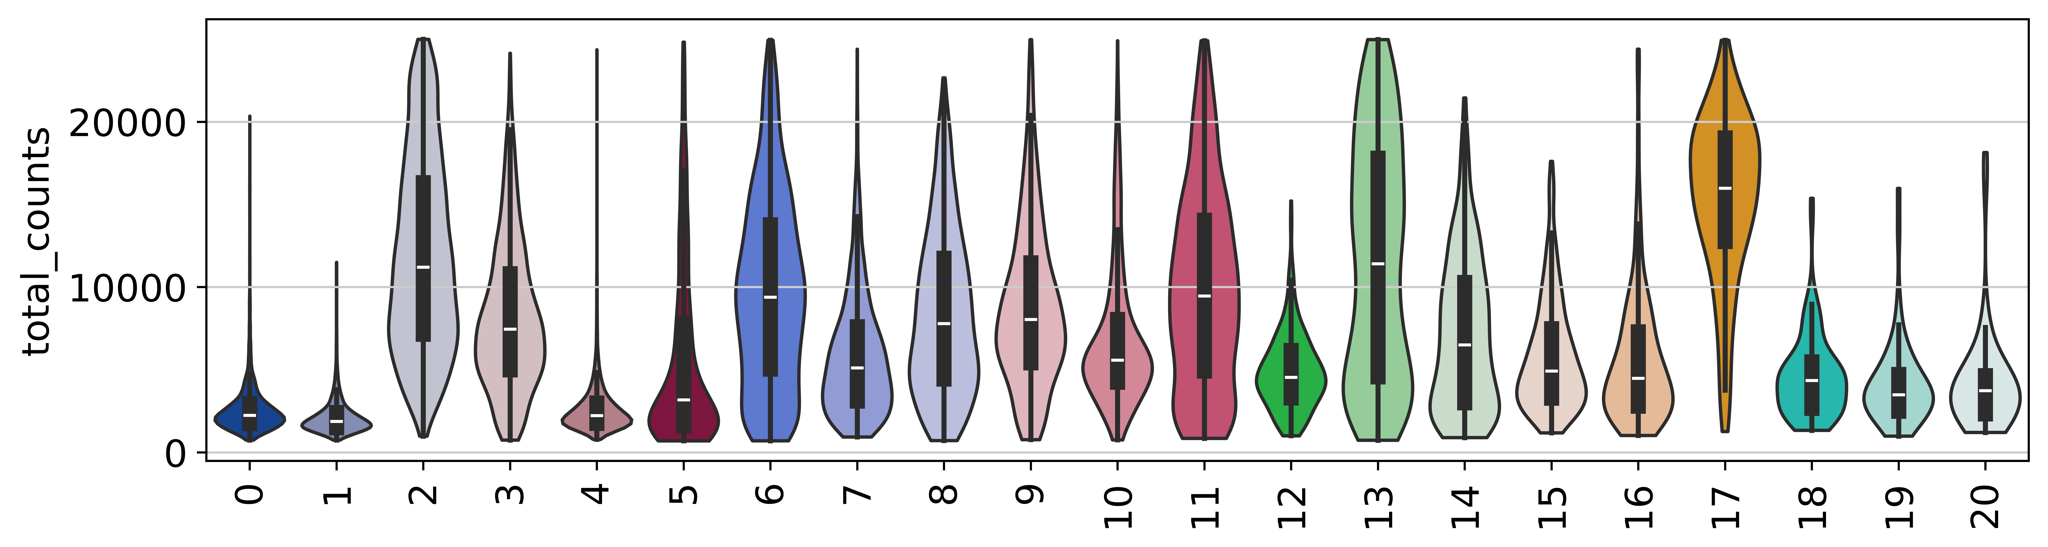

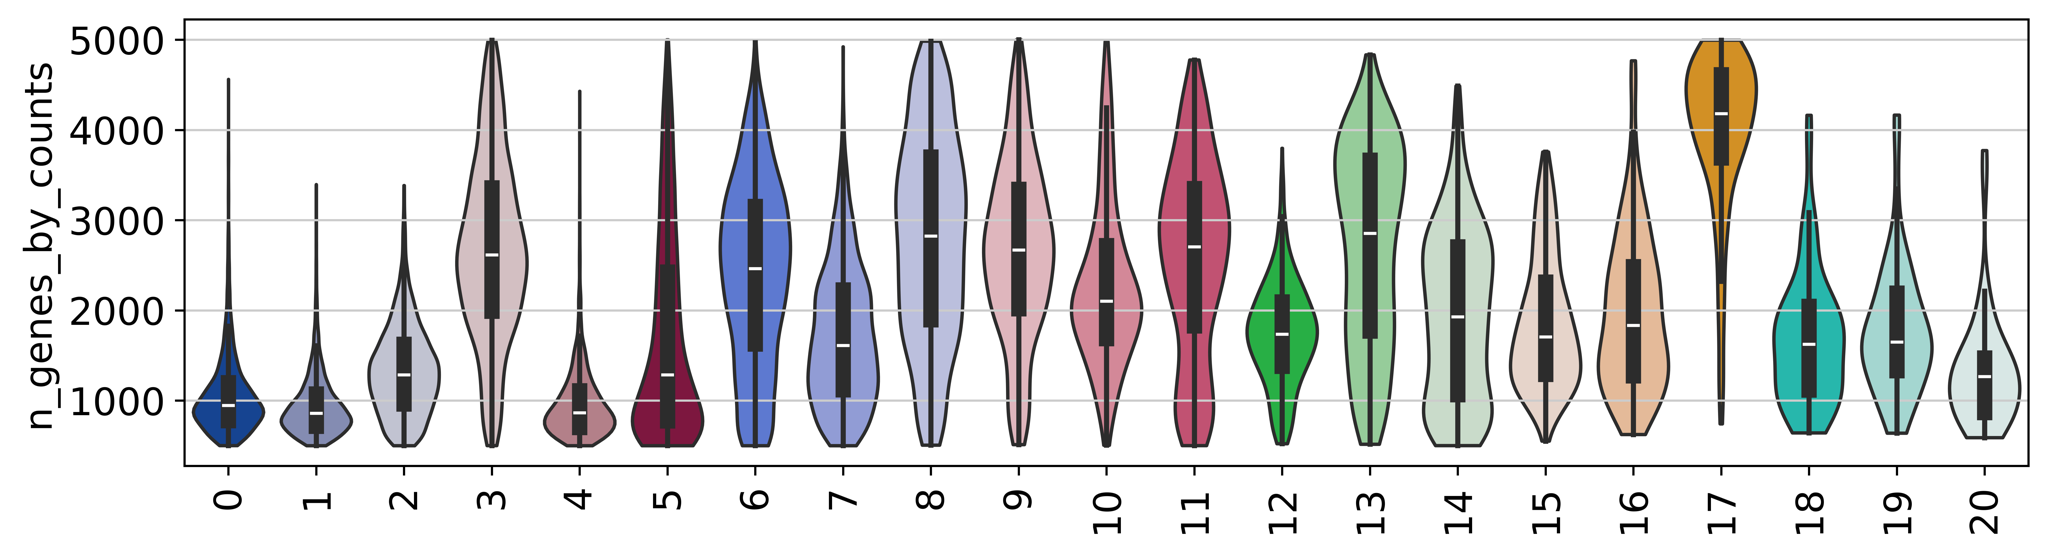

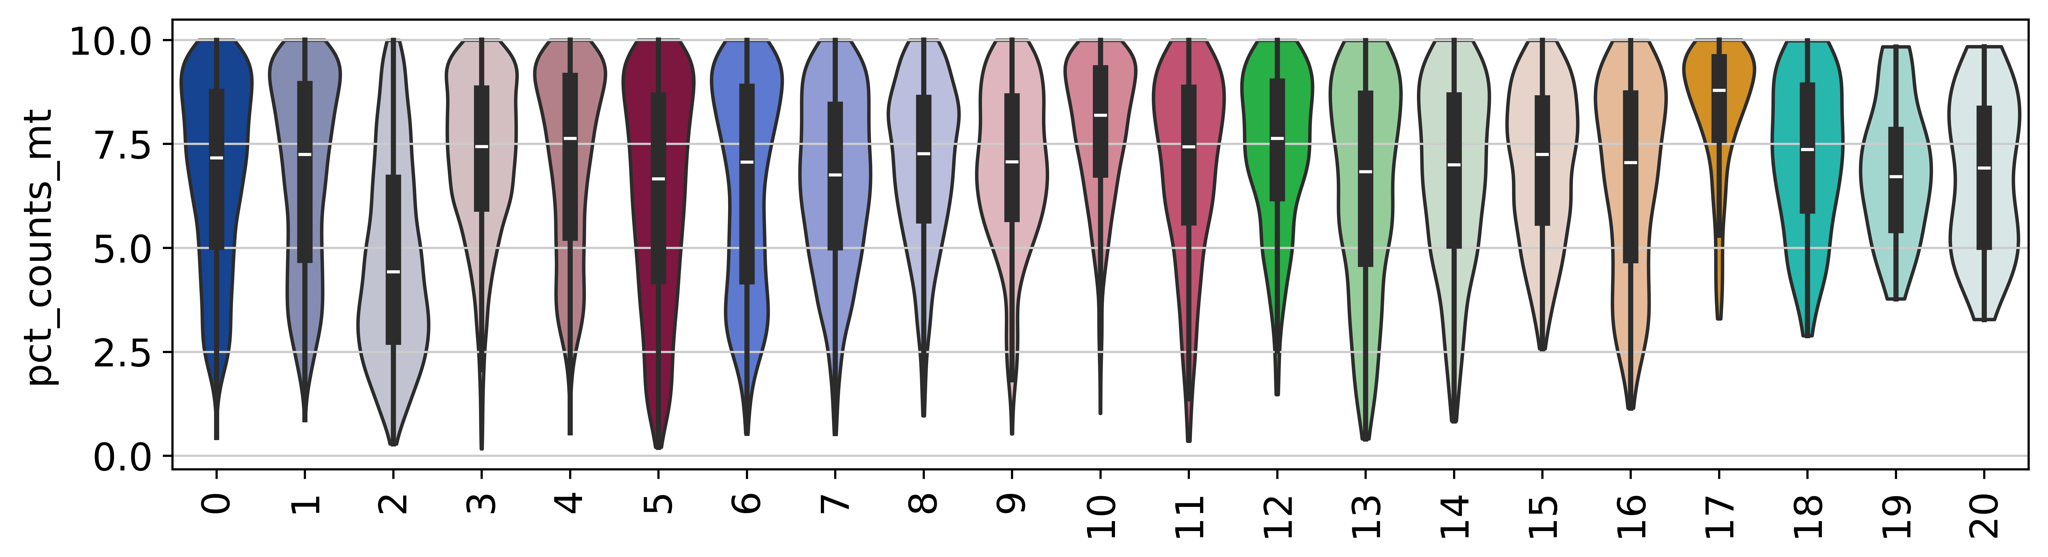

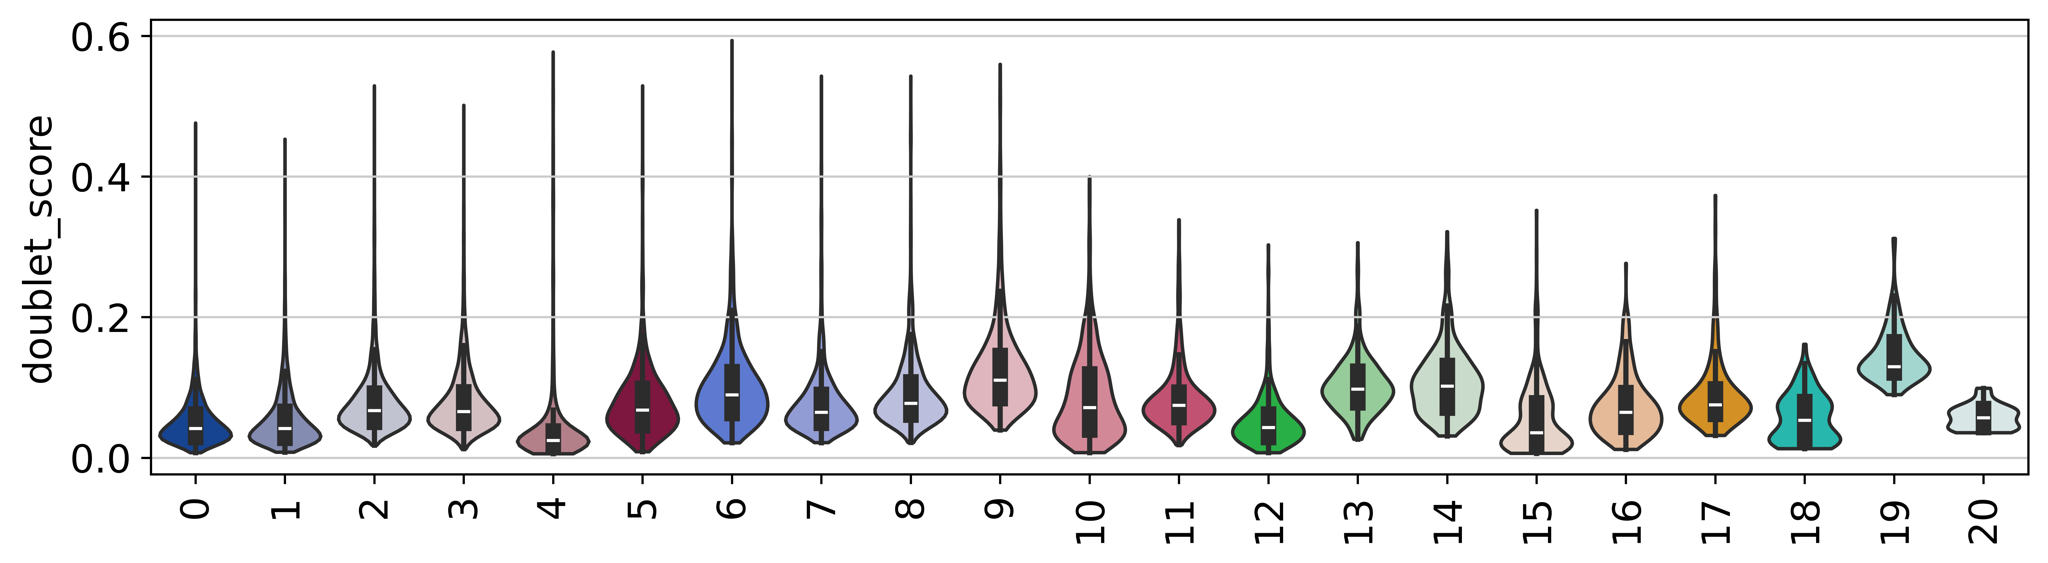

In [41]:
sc.settings.set_figure_params(dpi=400, dpi_save=400, figsize=(10,3), facecolor='white')
sc.pl.violin(adata,[ 'total_counts'], inner='box', size=0,  groupby='leiden_0.5', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='leiden_0.5', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'pct_counts_mt'], inner='box', size=0,  groupby='leiden_0.5', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'doublet_score'], inner='box', size=0,  groupby='leiden_0.5', multi_panel=False, rotation=90)

In [40]:
adata.obs.groupby('leiden_0.5').mean(numeric_only=True)

/scratch_tmp/24197881/ipykernel_204395/2970527052.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('leiden_0.5').mean(numeric_only=True)


doublet_score  Sample_num  n_genes_by_counts  total_counts  \
leiden_0.5                                                               
0                0.051091  217.153218        1046.870276   2569.393311   
1                0.054555  185.652026         936.708699   2118.701416   
2                0.078672  208.661290        1324.565149  11955.530273   
3                0.079000  212.761654        2672.464532   8168.979492   
4                0.042194  213.014085         954.832864   2595.781250   
5                0.077623  230.255738        1704.259563   5566.861328   
6                0.101578  164.254939        2397.745061   9774.272461   
7                0.077352  248.899779        1716.251290   5841.264648   
8                0.092303  249.357470        2801.745188   8430.201172   
9                0.125180  207.506849        2665.671233   8790.276367   
10               0.084824  220.601148        2278.384505   6802.538086   
11               0.085106  205.774194        2566.082437   9855.130859   
12               0.051626  201.089613        1738.191446   4875.902344   
13               0.101994  187.427948        2693.829694  11556.657227   
14               0.107392  218.157107        1949.069825   7155.109863   
15               0.053924  194.839378        1867.227979   5872.080078   
16               0.073738  222.472050        1965.652174   5621.111816   
17               0.089015  311.368794        3979.932624  15341.510742   
18               0.056553  184.978495        1679.741935   4573.677246   
19               0.145715  224.481481        1774.092593   4142.481445   
20               0.058442  182.000000        1320.400000   4257.355469   

            total_counts_mt  pct_counts_mt  
leiden_0.5                                  
0                176.543915       6.774172  
1                147.083878       6.782742  
2                510.809296       4.776221  
3                594.318604       7.209079  
4                188.847885       7.111099  
5                383.183075       6.294116  
6                670.818970       6.551548  
7                383.933685       6.613101  
8                599.192505       7.044332  
9                608.781860       6.982047  
10               529.652771       7.879054  
11               710.019714       6.977701  
12               365.193481       7.370306  
13               773.508728       6.473024  
14               497.573578       6.745466  
15               403.318665       7.005805  
16               379.040375       6.644866  
17              1294.297852       8.352585  
18               318.430115       7.172543  
19               274.074066       6.897528  
20               265.311096       6.771005

In [42]:
adata.obs['leiden_0.5'].value_counts()

leiden_0.5
0     3916
1     3529
2     3162
3     2467
4     2130
5     1830
6     1569
7     1357
8     1091
9      949
10     697
11     558
12     491
13     458
14     401
15     386
16     322
17     282
18      93
19      54
20      45
Name: count, dtype: int64